In [1]:

import pandas as pd
from wfield import *
import pickle
import sys
import os
# sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append('./ICA')
from NatMovie_utils import *
from os.path import join as pjoin
from glob import glob

from jadeR import jadeR
from jadeR_cupy import jadeR_cupy

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import cupy as cp


## batch process

In [3]:

path_list = glob(pjoin('Y:/WF_VC_liuzhaoxi/','*/natural-movie*/process/*-wfield'))
path_list

['Y:/WF_VC_liuzhaoxi\\24.01.03_C83\\natural-movie\\process\\20240103-131221-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.01.22_C83\\natural-movie\\process\\20240122-194422-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.03.27_C92\\natural-movie\\process\\20240327-183009-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.04.03_C92\\natural-movie\\process\\20240403-161209-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.04.03_C92\\natural-movie\\process\\20240403-172109-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.04.03_C92\\natural-movie\\process\\20240403-192107-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.05.07_H78\\natural-movie\\process\\20240507-113351-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.05.07_H78\\natural-movie\\process\\20240507-121035-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.05.07_H78-DOM\\natural-movie\\process\\20240507-182626-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.05.20_H78\\natural-movie\\process\\20240520-180021-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.05.20_H78\\natural-movie\\process\\20240520-185133-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.07.08_Q20\\natural-movie\\process\\2

In [4]:
path_list=path_list[15:]
path_list

['Y:/WF_VC_liuzhaoxi\\24.11.11_H78\\natural-movie\\process\\20241111-215658-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.11.11_H78\\natural-movie-invert\\process\\20241111-223236-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.11.11_H78\\natural-movie-reverse\\process\\20241111-230416-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.12.19_P41\\natural-movie\\process\\20241219-182821-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.12.19_P41\\natural-movie\\process\\20241219-183603-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.12.19_P41\\natural-movie\\process\\20241219-192319-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.12.19_P41\\natural-movie-invert\\process\\20241219-201009-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.12.19_P41\\natural-movie-invert\\process\\20241219-231104-wfield',
 'Y:/WF_VC_liuzhaoxi\\24.12.19_P41\\natural-movie-reverse\\process\\20241219-210558-wfield',
 'Y:/WF_VC_liuzhaoxi\\25.01.10_P41\\natural-movie\\process\\20250110-013702-wfield',
 'Y:/WF_VC_liuzhaoxi\\25.01.10_P41\\natural-movie-invert\\process\\20250110-020719-wfield',
 'Y:/WF_VC_liuzhaoxi\

In [ ]:
for path_wfield in path_list: 
    print('\n\n\n'+path_wfield)
    experiment = os.path.basename(path_wfield)[:15]
    mouse = os.path.normpath(path_wfield).split(os.sep)[5].split('_')[1]
    print(experiment, mouse)
    trialfile = pd.read_csv(pjoin(path_wfield, 'trials.csv'), header=None).values.astype(int)
    if trialfile.shape[0] < 70:
        print("This experiment is not complete, skip.")
        continue
    path_out = pjoin(path_wfield, '..', experiment + '-natural-movie--')
    os.makedirs(path_out, exist_ok=True)
    rawPath = pjoin(path_wfield, '../../raw')
    movie_folder = pjoin(rawPath, 'natural_movies')
    movie_list = pd.read_csv(pjoin(movie_folder, 'movie_list.txt'), header=None).values
    n_movie = movie_list.size
    movie_name_list = []
    for imovie in range(n_movie):
        movie_name_list.append(str(movie_list[imovie])[2:-6])
    
    n_frame = 150  # 帧
    pre_length = 20
    after_lenth = 30
    whole_length = trialfile[-1, 2] + 50
    frames_average = np.load(pjoin(path_wfield, 'frames_average.npy')).astype('float32')
    
    
    # generate tif_sort
    if os.path.exists(pjoin(path_out, f'{mouse}_{experiment}_tif_sort.npy')):
        print('loading tif_sort.npy')
        tif_sort1 = cp.load(pjoin(path_out, f'{mouse}_{experiment}_tif_sort.npy'))
        tif_sort = cp.asnumpy(tif_sort1)
        print('tiff_sort.shape: (height, width, n_frame, n_movie, n_rep) ', tif_sort.shape)
        tif_height, tif_width = tif_sort.shape[:2]
        n_rep = tif_sort.shape[-1]
    
    else:
        # tif = mmap_dat(glob(pjoin(path_wfield, "*.bin"))[0])
        # tif470 = (tif[:,0]-frames_average[0])/frames_average[0]
        # tif405 = (tif[:,1]-frames_average[1])/frames_average[1]
        # tif_corr=tif470-tif405
        # print('finish tif_corr')
        # tif_height,tif_width=tif_corr.shape[1:]
    
        U = cp.load(pjoin(path_wfield, 'U.npy')).astype('float32')
        SVT = cp.load(pjoin(path_wfield, 'SVT.npy')).astype('float32')
        SVT_470 = SVT[:, ::2]
        SVT_405 = SVT[:, 1::2]
        SVTcorr = SVT_470 - SVT_405
        # SVTcorr = cp.load(pjoin(path_wfield, 'SVTcorr.npy')).astype('float32')
        tif_height, tif_width = U.shape[:2]
    
        # SVTcorr_sort维度：[nSVD, n_frame, n_movie, n_rep]
        SVTcorr_sort = Gsorting_NatMov(SVTcorr, trialfile[:, 1], n_movie, n_frame, pre_length, after_lenth).astype(
            'float32')
        n_rep = SVTcorr_sort.shape[-1]
        tif_sort1 = cp.tensordot(U, SVTcorr_sort, axes=(2, 0)).astype('float32')
        tif_sort = cp.asnumpy(tif_sort1)
        np.save(pjoin(path_out, f'{mouse}_{experiment}_tif_sort.npy'), tif_sort)
        print('finish save tif_sort.npy')
        print('tif_sort维度：[width, height, n_frame, n_movie, n_rep]')
        print(tif_sort.shape)
    
    
    
    # load CCF
    lmarks = load_allen_landmarks(pjoin(path_wfield, '../../../', 'dorsal_cortex_landmarks.json'))
    ccf_regions_reference, proj, brain_outline = allen_load_reference('dorsal_cortex')
    # this loads the untransformed atlas
    atlas_im, areanames, brain_mask = atlas_from_landmarks_file(
        pjoin(path_wfield, '../../../', 'dorsal_cortex_landmarks.json'),
        do_transform=True)
    # this converts the reference to image space (unwarped)
    ccf_regions_im = allen_transform_regions(lmarks['transform'], ccf_regions_reference,
                                            resolution=lmarks['resolution'],
                                            bregma_offset=lmarks['bregma_offset'])
    
    # plot avg_frame & CCF
    fig = plt.figure()
    plt.imshow(frames_average[0], cmap='gray')
    for i, r in ccf_regions_im.iterrows():
        plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
        plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
        plt.text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=5, alpha=0.5, ha='center')
    
    plt.axis('off')
    plt.title(f'{mouse}_{experiment}_CCF')
    fig.set_facecolor('white')
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_ccf.png'), bbox_inches='tight', pad_inches=0)
    plt.show()
    
    from skimage.transform import warp
    
    ccf_regions = allen_transform_regions(None, ccf_regions_reference,
                                        resolution=lmarks['resolution'],
                                        bregma_offset=lmarks['bregma_offset'])
    
    frames_average_warped = warp(frames_average.transpose(1, 2, 0), lmarks['transform'],
                                order=1, mode='constant', cval=0, clip=True, preserve_range=True,
                                output_shape=(540, 640)).transpose(2, 0, 1)
    
    # plot warped avg_frame & CCF
    
    fig = plt.figure()
    plt.imshow(frames_average_warped[0], cmap='gray')
    for i, r in ccf_regions.iterrows():
        plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
        plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
        plt.text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=5, alpha=0.5, ha='center')
    
    plt.axis('off')
    plt.title(f'{mouse}_{experiment}_CCF_warped')
    fig.set_facecolor('white')
    plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_ccf_warped.png'), bbox_inches='tight', pad_inches=0)
    plt.show()
    
    
    # calculate area_timecourse
    def flat_mask(Uflat, xy):
        # index are in xy, like what np.where(mask) returns
        x = np.array(np.clip(xy[0], 0, tif_height - 1), dtype=int)
        y = np.array(np.clip(xy[1], 0, tif_width - 1), dtype=int)
        idx = np.ravel_multi_index((x, y), (tif_height, tif_width))
        t = Uflat[idx, :]
        return t
    
    
    tif_sort_flat = cp.asnumpy(tif_sort.reshape(tif_height * tif_width, -1))
    all_area_timecourse = np.empty((33, tif_sort_flat.shape[-1]))
    for area in range(1, 34):
        all_area_timecourse[area - 1] = flat_mask(tif_sort_flat, np.where(atlas_im == area)).mean(axis=0)
    
    np.save(pjoin(path_out, f'{mouse}_{experiment}_all_area_timecourse.npy'),
            all_area_timecourse.reshape(33, *tif_sort.shape[2:]))
    print('finish saving all_area_timecourse')
    
    
    # Plot the overlap for the same region in the warped versus unwarped atlases 
    bg = 0
    aud = range(20, 24)
    soma = [5, 6]
    visual = range(24, 34)
    
    plt.figure(figsize=[5, 5])
    reg = np.zeros([*atlas_im.shape, 3])
    reg[:, :, 0] = np.isin(atlas_im, visual) * 200
    reg[:, :, 1] = np.isin(atlas_im, soma) * 200
    reg[:, :, 2] = np.isin(atlas_im, aud) * 100
    plt.imshow(reg.astype('uint8'))
    
    for i, r in ccf_regions_im.iterrows():
        for side in ['left', 'right']:
            plt.plot(np.array(r[side + '_x']), r[side + '_y'], 'w', lw=1)
            plt.text(r.left_center[0], r.left_center[1], str(i + 1) + '-' + r.acronym, color='w', va='center', fontsize=4,
                    alpha=1, ha='center')
    plt.axis('off')
    # plt.savefig('/home/lzx/data/WF_VC_liuzhaoxi/______________natural_movie_summary/brain areas.png')
    plt.show()
    
    
    # plot area_timecourse
    visual_timecourse = flat_mask(tif_sort_flat, np.where(np.isin(atlas_im, visual))).reshape(-1, *tif_sort.shape[2:])
    soma_timecourse = flat_mask(tif_sort_flat, np.where(np.isin(atlas_im, soma))).reshape(-1, *tif_sort.shape[2:])
    aud_timecourse = flat_mask(tif_sort_flat, np.where(np.isin(atlas_im, aud))).reshape(-1, *tif_sort.shape[2:])
    print('visual timecourse:', visual_timecourse.shape)
    print('soma timecourse:', soma_timecourse.shape)
    print('aud timecourse:', aud_timecourse.shape)
    
    VAS_timecourse = np.stack((visual_timecourse.mean(axis=0).transpose(1, 0, 2),
                            aud_timecourse.mean(axis=0).transpose(1, 0, 2),
                            soma_timecourse.mean(axis=0).transpose(1, 0, 2)),
                            axis=0)
    VA_timecourse = np.empty((10, *tif_sort.shape[2:]))
    for i, i_area in enumerate(range(24, 34)):
        VA_timecourse[i] = flat_mask(tif_sort_flat, np.where(np.isin(atlas_im, i_area))).reshape(-1, *tif_sort.shape[2:]).mean(axis=0)
    subplot_timecourse(VAS_timecourse, patch_list=['visual', 'auditory', 'somatosensory'],
                    movie_name_list=movie_name_list, title=f'{mouse}_{experiment}_VAS timecourse',
                    outpath=path_out, pre_length=20, n_frame=150, plot_rep=False, dpi=200)
    
    VA_list = ['VISli', 'VISpor', 'VISpl', 'VISpm', 'VISl', 'VISal', 'VISrl', 'VISa', 'VISam', 'V1']
    subplot_timecourse(VA_timecourse.transpose(0, 2, 1, 3), patch_list=VA_list,
                    movie_name_list=movie_name_list, title=f'{mouse}_{experiment}_visual area timecourse',
                    outpath=path_out, pre_length=20, n_frame=150, plot_rep=False, dpi=200)
    
    
    # calculate area lag correlation
    area_list = ['MOB', 'FRP', 'MOp', 'MOs', 'SSp-n', 'SSp-m', 'SSp-un', 'PL', 'ACAd', 'RSPv', 'RSPd', 'RSPagl', 'VISC',
                'SSs', 'SSp-bfd', 'SSp-tr', 'SSp-ll', 'SSp-ul', 'TEa', 'AUDd', 'AUDp', 'AUDpo', 'AUDv',
                'VISli', 'VISpor', 'VISpl', 'VISpm', 'VISl', 'VISal', 'VISrl', 'VISa', 'VISam', 'VISp']
    
    area_list1 = ['MOB', 'FRP', 'MOp', 'MOs', 'PL', 'ACAd', 'RSPv', 'RSPd', 'RSPagl', 'VISC',
                'SSp-n', 'SSp-m', 'SSp-un', 'SSs', 'SSp-bfd', 'SSp-tr', 'SSp-ll', 'SSp-ul', 'TEa', 'AUDd', 'AUDp',
                'AUDpo', 'AUDv',
                'VISli', 'VISpor', 'VISpl', 'VISpm', 'VISl', 'VISal', 'VISrl', 'VISa', 'VISam', 'VISp']
    
    area_idx = [area_list.index(area) for area in area_list1]
    
    from scipy.signal import correlate
    import numpy as np
    
    def compute_lag_correlation(matrix):
        """
        计算矩阵中每一行之间的归一化 lag correlation 和对应滞后。
    
        参数:
            matrix (numpy.ndarray): 输入二维矩阵，形状为 (n_rows, n_cols)
    
        返回:
            max_corr_matrix (numpy.ndarray): 最大绝对值相关性矩阵，形状为 (n_rows, n_rows)
            max_lag_matrix (numpy.ndarray): 最大相关性对应的滞后矩阵，形状为 (n_rows, n_rows)
        """
        n_rows = matrix.shape[0]
        max_corr_matrix = np.zeros((n_rows, n_rows))
        max_lag_matrix = np.zeros((n_rows, n_rows))
    
        for i in range(n_rows):
            for j in range(i, n_rows):  # 只计算上三角矩阵
                # 提取信号
                x = matrix[i]
                y = matrix[j]
    
                # 零均值处理
                x = x - np.mean(x)
                y = y - np.mean(y)
    
                # 计算 cross-correlation
                corr = correlate(x, y, mode='full', method='auto')
    
                # 归一化：除以 (std(x) * std(y) * len(x))
                normalization_factor = np.std(x) * np.std(y) * len(x)
                corr /= normalization_factor  # 将结果限制在 [-1, 1]
    
                # 找到最大绝对值相关性
                max_corr_idx = np.argmax(np.abs(corr))
                max_corr = corr[max_corr_idx]
                lag = max_corr_idx - (len(x) - 1)
    
                # 填入矩阵
                max_corr_matrix[i, j] = max_corr
                max_corr_matrix[j, i] = max_corr  # 对称性
                max_lag_matrix[i, j] = lag
                max_lag_matrix[j, i] = -lag  # 滞后是反对称的
    
        return max_corr_matrix, max_lag_matrix
    
    area_corr, area_lag = compute_lag_correlation(all_area_timecourse[area_idx])
    np.save(pjoin(path_out, f'{mouse}_{experiment}_all area correlation.npy'), area_corr)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_all area correlation lag.npy'), area_lag)
    
    
    
    plot_heatmap(area_corr, xlabel=area_list1, ylabel=area_list1, cmap='coolwarm', vmin=None, vmax=None,
                title=f'{mouse}_{experiment}_all area correlation',
                outfile=pjoin(path_out, f'{mouse}_{experiment}_all area correlation.png'), dpi=300, annot=True)
    plot_heatmap(area_lag, xlabel=area_list1, ylabel=area_list1, cmap='coolwarm', vmin=None, vmax=None,
                title=f'{mouse}_{experiment}_all area correlation lag',
                outfile=pjoin(path_out, f'{mouse}_{experiment}_all area correlation lag.png'), dpi=300, annot=True)
    
    
    # calculate and plot std & snr
    std = np.std(tif_sort, axis=(2, 4))
    subplot_movie_heatmap(std, 4, 4, movie_name_list, path_outfile=pjoin(path_out, f'{mouse}_{experiment}_std.png'),
                        title=f'{mouse}_{experiment}_std', vmax=0.1, pixel_um=26, patches=None,
                        ccf_regions=ccf_regions_im)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_std.npy'), std)
    
    std_warped = warp(std, lmarks['transform'],
                    order=1, mode='constant', cval=0, clip=True, preserve_range=True, output_shape=(540, 640))
    subplot_movie_heatmap(std_warped, 4, 4, movie_name_list,
                        path_outfile=pjoin(path_out, f'{mouse}_{experiment}_std_warped.png'),
                        title=f'{mouse}_{experiment}_std_warped', vmax=0.1, pixel_um=26, patches=None,
                        ccf_regions=ccf_regions)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_std_warped.npy'), std_warped)
    
    # snr = cal_snr(tif_sort, axis1=4, axis2=2)
    snr = cp.asnumpy(Gcal_snr(tif_sort1, axis1=4, axis2=2))
    subplot_movie_heatmap(snr, 4, 4, movie_name_list,
                        path_outfile=pjoin(path_out, f'{mouse}_{experiment}_snr.png'),
                        title=f'{mouse}_{experiment}_snr', vmax=3, pixel_um=26, patches=None,
                        ccf_regions=ccf_regions_im)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_snr.npy'), snr)
    
    snr_warped = warp(snr, lmarks['transform'],
                    order=1, mode='constant', cval=0, clip=True, preserve_range=True, output_shape=(540, 640))
    subplot_movie_heatmap(snr_warped, 4, 4, movie_name_list,
                        path_outfile=pjoin(path_out, f'{mouse}_{experiment}_snr_warped.png'),
                        title=f'{mouse}_{experiment}_snr_warped', vmax=3, pixel_um=26, patches=None,
                        ccf_regions=ccf_regions)
    np.save(pjoin(path_out, f'{mouse}_{experiment}_snr_warped.npy'), snr_warped)
    
    
    
    ### ~~~~~~~~~~~~~~~~~~ start spatial ICA ~~~~~~~~~~~~~~~~~~~~
    
    path_out_ICA = pjoin(path_wfield, '..', experiment + '-natural-movie--', f'{mouse}-{experiment}-ICA')
    os.makedirs(path_out_ICA, exist_ok=True)
    frames_ave = np.load(pjoin(path_wfield, 'frames_average.npy'))[0]
    
    
    # set ICA parameter
    ICA_methods = 'jade'
    n_IC = 20
    
    # X = tif_corr.reshape(SVTcorr.shape[-1], -1)
    # tif_sort维度：[width, height, n_frame, n_movie, n_rep]
    X = tif_sort1.reshape(tif_width * tif_height, -1).T
    print('ICA dim:', X.shape)
    if ICA_methods == 'jade':
        demix_matrix = jadeR_cupy(X, m=n_IC, verbose=True)
        IC = demix_matrix @ X
        IC_array = cp.asnumpy(IC).reshape(n_IC, *tif_sort.shape[:2])
        mix_matrix = cp.asnumpy(cp.linalg.pinv(demix_matrix))
    
        del X, demix_matrix, IC
        cp._default_memory_pool.free_all_blocks()
    
    # elif ICA_methods == 'fast':
    #     from sklearn.decomposition import FastICA
    
    #     tif_corr_bin2 = tif_corr.reshape(tif_corr.shape[0], tif_corr.shape[1] // 2, 2, tif_corr.shape[2] // 2, 2).mean(
    #         axis=(2, 4))
    #     X_bin2 = tif_corr_bin2.reshape(tif_corr.shape[0], -1)
    #     fastica = FastICA(n_components=n_IC, whiten="arbitrary-variance")
    #     IC = fastica.fit_transform(X_bin2.T).T
    #     mix_matrix = fastica.mixing_
    #     IC_array_bin2 = np.asarray(IC).reshape(n_IC, *tif_corr_bin2.shape[1:])
    #     IC_array = np.kron(IC_array_bin2, np.ones((1, 2, 2)))
    
    np.save(pjoin(path_out_ICA, f'{mouse}_{experiment}_spatial_IC{n_IC}.npy'), IC_array)
    np.save(pjoin(path_out_ICA, f'{mouse}_{experiment}_IC{n_IC}_mix.npy'), mix_matrix)
    print('save ICA matrix')
    print('IC_array.shape', IC_array.shape)
    print('mix_matrix.shape', mix_matrix.shape)
    IC_array = np.load(pjoin(path_out_ICA, f'{mouse}_{experiment}_spatial_IC{n_IC}.npy'))
    mix_matrix = np.load(pjoin(path_out_ICA, f'{mouse}_{experiment}_IC{n_IC}_mix.npy'))
    # mix_matrix_sort = np.load(pjoin(path_out_ICA, f'{mouse}_{experiment}_IC{n_IC}_mix_matrix_sort.npy'))
    
    
    # set IC threshold, adjust ± sign
    def zscore(matrix, axis=(1, 2)):
        mean = np.mean(matrix, axis=axis)
        std = np.std(matrix, axis=axis)
        zscore_matrix = (matrix - mean[:, None, None]) / std[:, None, None]
        return zscore_matrix
    
    
    IC_arrayz = zscore(IC_array)
    IC_arrayz_cut = np.copy(IC_arrayz)
    
    z_cut = 3
    IC_arrayz_cut[np.abs(IC_arrayz_cut) < z_cut] = 0
    # IC_arrayz_cut[np.abs(IC_arrayz_cut) >= z_cut] = 1
    ic_sign = np.where(np.mean(IC_arrayz_cut, axis=(1, 2)) < 0, -1, 1)
    IC_arrayz_cut = ic_sign[:, None, None] * IC_arrayz_cut  # 确保IC方向为正
    mix_matrix = ic_sign * mix_matrix
    
    
    ##find cluster
    def find_cluster(binary_image, area):
        """
    
        binary_image: (size1,size2),is a 2D matrix that has already been binarized
        area: int, the minimum area of the cluster,50~100 is a good choice for me
        """
        from scipy.ndimage import label, find_objects
        labeled_array, cluster_num = label(binary_image)
        print(f'cluster_num: {cluster_num}')
        objects = find_objects(labeled_array)
        new_binary_image = np.zeros_like(binary_image)
        for i in range(1, cluster_num + 1):
            cluster = (labeled_array == i)
            new_binary_image[cluster] = cluster.sum() >= area
        return new_binary_image
    
    
    IC_arrayz_cut_cluster = np.zeros((n_IC, tif_height, tif_width))
    for iIC in range(n_IC):
        IC_arrayz_cut_cluster[iIC] = find_cluster(IC_arrayz_cut[iIC], 100)
    np.save(pjoin(path_out_ICA, f'{mouse}_{experiment}_IC{n_IC}_cut{z_cut}_cluster.npy'), IC_arrayz_cut_cluster)
    
    
    # plot spatial IC
    nrow = 4
    ncol = 5
    dpi = 200
    
    fig, ax = plt.subplots(nrow, ncol, figsize=(tif_height / dpi * ncol, tif_width / dpi * nrow), dpi=dpi)
    for irow in range(nrow):
        for icol in range(ncol):
            iIC = irow * ncol + icol
            ax[irow, icol].imshow(frames_ave, cmap='gray')
            img = ax[irow, icol].imshow(IC_arrayz_cut_cluster[iIC], cmap='coolwarm', clim=[-1, 1], alpha=0.5)
            ax[irow, icol].set_title('IC{}'.format(iIC + 1), fontsize=10)
            ax[irow, icol].axis('off')
    
            for idx, r in ccf_regions_im.iterrows():
                ax[irow, icol].plot(r['left_x'], r['left_y'], 'k', lw=0.2)
                ax[irow, icol].plot(r['right_x'], r['right_y'], 'k', lw=0.2)
                ax[irow, icol].text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=2,
                                    alpha=0.5,
                                    ha='center')
            fig.colorbar(img)
    fig.set_facecolor('white')
    fig.suptitle(f'{mouse}_{experiment}\nIC{n_IC} (cut={z_cut})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(pjoin(path_out_ICA, f'{mouse}_{experiment}_IC{n_IC}.png'), bbox_inches='tight', pad_inches=0)
    plt.show()
    
    from skimage.transform import warp
    
    ccf_regions = allen_transform_regions(None, ccf_regions_reference,
                                        resolution=lmarks['resolution'],
                                        bregma_offset=lmarks['bregma_offset'])
    
    IC_arrayz_cut_cluster_warped = warp(IC_arrayz_cut_cluster.transpose(1, 2, 0), lmarks['transform'],
                                        order=1, mode='constant', cval=0, clip=True, preserve_range=True,
                                        output_shape=(540, 640)).transpose(2, 0, 1)
    np.save(pjoin(path_out_ICA, f'{mouse}_{experiment}_IC{n_IC}_cut{z_cut}_cluster_warped.npy'),
            IC_arrayz_cut_cluster_warped)
    
    frames_average_warped = warp(frames_average.transpose(1, 2, 0), lmarks['transform'],
                                order=1, mode='constant', cval=0, clip=True, preserve_range=True,
                                output_shape=(540, 640)).transpose(2, 0, 1)
    
    
    # plot warped spatial IC
    nrow = 4
    ncol = 5
    dpi = 200
    
    fig, ax = plt.subplots(nrow, ncol, figsize=(tif_height / dpi * ncol, tif_width / dpi * nrow), dpi=dpi)
    for irow in range(nrow):
        for icol in range(ncol):
            iIC = irow * ncol + icol
            ax[irow, icol].imshow(frames_average_warped[0], cmap='gray')
            img = ax[irow, icol].imshow(IC_arrayz_cut_cluster_warped[iIC], cmap='coolwarm', clim=[-1, 1], alpha=0.5)
            ax[irow, icol].set_title('IC{}'.format(iIC + 1), fontsize=10)
            ax[irow, icol].axis('off')
    
            for idx, r in ccf_regions.iterrows():
                ax[irow, icol].plot(r['left_x'], r['left_y'], 'k', lw=0.2)
                ax[irow, icol].plot(r['right_x'], r['right_y'], 'k', lw=0.2)
                ax[irow, icol].text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=2,
                                    alpha=0.5,
                                    ha='center')
            fig.colorbar(img)
    fig.set_facecolor('white')
    fig.suptitle(f'{mouse} {experiment}\nspatial_IC{n_IC}_warped (cut={z_cut})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(pjoin(path_out_ICA, f'{mouse}_{experiment}_spatial-IC{n_IC}_warped.png'), bbox_inches='tight', pad_inches=0)
    plt.show()
    
    
    
    # plot superimposed spatial IC
    
    from matplotlib.colors import ListedColormap
    
    color_list = [
        "#B0C4DE", "#F4A460", "#87CEFA", "#FFB6C1", "#90EE90", "#4682B4", "#D8BFD8",
        "#BDB76B", "#8FBC8F", "#F08080", "#BC8F8F", "#87CEEB", "#CDAA7D", "#B0E0E6",
        "#CD853F", "#ADD8E6", "#B0E57C", "#F0E68C", "#DAA520", "#AFEEEE", "#DDA0DD",
        "#A52A2A", "#8B4513", "#5F9EA0", "#F5DEB3", "#D2B48C", "#F4C2C2", "#E6E6FA",
        "#EEE8AA", "#B4CDCD", "#FFE4B5", "#E0FFFF", "#DB7093", "#468499", "#FFD700",
        "#40E0D0", "#FF6347", "#7FFFD4", "#FF7F50", "#9370DB", "#FF69B4", "#00CED1",
        "#FFA07A", "#20B2AA", "#FF4500", "#FF8C00", "#6495ED", "#FF6347", "#4169E1",
        "#DA70D6", "#98FB98", "#FF1493", "#32CD32", "#00FA9A", "#F08080", "#FFDAB9",
        "#BA55D3", "#00FF7F", "#8A2BE2", "#4682B4", "#F5DEB3", "#00BFFF"
    ]
    
    fig, ax = plt.subplots()
    plt.imshow(frames_ave, cmap='gray')
    
    # 逐个叠加IC，使用不同颜色
    for i in range(n_IC):
        cmap = ListedColormap(['None', color_list[i]])
        plt.imshow(IC_arrayz_cut_cluster[i], cmap=cmap, interpolation='nearest', alpha=0.5)
    
    for i, r in ccf_regions_im.iterrows():
        plt.plot(r['left_x'], r['left_y'], 'w', lw=0.2)
        plt.plot(r['right_x'], r['right_y'], 'w', lw=0.2)
        plt.text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=4, alpha=0.5, ha='center')
    
    # plot_borders(retino['finalPatchesMarked'], plotAxis=ax, title=None, zoom=1,
    #                  borderWidth=1, isColor=True, plotName=True, fontSize=7)
    
    plt.axis('off')
    # plt.colorbar()
    fig.set_facecolor('white')
    plt.title(f'{mouse}_{experiment}\nsum IC{n_IC}(cut={z_cut})')
    plt.savefig(pjoin(path_out_ICA, f'{mouse}_{experiment}_sum IC{n_IC}___colored.png'), bbox_inches='tight', pad_inches=0)
    plt.show()
    
    
    # plot warped superimposed spatial IC
    
    from matplotlib.colors import ListedColormap
    
    color_list = [
        "#B0C4DE", "#F4A460", "#87CEFA", "#FFB6C1", "#90EE90", "#4682B4", "#D8BFD8",
        "#BDB76B", "#8FBC8F", "#F08080", "#BC8F8F", "#87CEEB", "#CDAA7D", "#B0E0E6",
        "#CD853F", "#ADD8E6", "#B0E57C", "#F0E68C", "#DAA520", "#AFEEEE", "#DDA0DD",
        "#A52A2A", "#8B4513", "#5F9EA0", "#F5DEB3", "#D2B48C", "#F4C2C2", "#E6E6FA",
        "#EEE8AA", "#B4CDCD", "#FFE4B5", "#E0FFFF", "#DB7093", "#468499", "#FFD700",
        "#40E0D0", "#FF6347", "#7FFFD4", "#FF7F50", "#9370DB", "#FF69B4", "#00CED1",
        "#FFA07A", "#20B2AA", "#FF4500", "#FF8C00", "#6495ED", "#FF6347", "#4169E1",
        "#DA70D6", "#98FB98", "#FF1493", "#32CD32", "#00FA9A", "#F08080", "#FFDAB9",
        "#BA55D3", "#00FF7F", "#8A2BE2", "#4682B4", "#F5DEB3", "#00BFFF"
    ]
    
    fig, ax = plt.subplots()
    plt.imshow(frames_average_warped[0], cmap='gray')
    
    # 逐个叠加IC，使用不同颜色
    for i in range(n_IC):
        cmap = ListedColormap(['None', color_list[i]])
        plt.imshow(IC_arrayz_cut_cluster_warped[i], cmap=cmap, interpolation='nearest', alpha=0.5)
    
    for i, r in ccf_regions.iterrows():
        plt.plot(r['left_x'], r['left_y'], 'w', lw=0.2)
        plt.plot(r['right_x'], r['right_y'], 'w', lw=0.2)
        plt.text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=4, alpha=0.5, ha='center')
    
    # plot_borders(retino['finalPatchesMarked'], plotAxis=ax, title=None, zoom=1,
    #                  borderWidth=1, isColor=True, plotName=True, fontSize=7)
    
    plt.axis('off')
    # plt.colorbar()
    fig.set_facecolor('white')
    plt.title(f'{mouse}_{experiment}\nsum IC{n_IC}(cut={z_cut})')
    plt.savefig(pjoin(path_out_ICA, f'{mouse}_{experiment}_sum IC{n_IC}___colored_warped.png'), bbox_inches='tight',
                pad_inches=0)
    plt.show()
    
    
    
    # align timecourse
    
    # pre_length = 20
    # after_length = 30
    # # mix_matrix.T: [n_IC, n_frame] 
    # # timecourse: [n_IC, n_frame, n_movie, n_rep]
    # timecourse = sorting_NatMov(mix_matrix.T, trialfile[:, 1], n_movie, n_frame, pre_length, after_length).astype('float32')
    timecourse = mix_matrix.T.reshape(n_IC, *tif_sort.shape[2:])
    np.save(pjoin(path_out_ICA, f'{mouse}_{experiment}_IC{n_IC}_timecourse.npy'), timecourse)
    print('timecourse.shape: (n_IC, n_frame, n_movie, n_rep) ', timecourse.shape)
    # n_rep = timecourse.shape[-1] 
    # # timecourse_mean = np.mean(timecourse, axis=3)
    
    
    
    # select top10 SNR ICs.
    timecourse_snr = cal_snr(timecourse, axis1=3, axis2=1)
    print('timecourse_snr.shape', timecourse_snr.shape)
    
    IC_idx = np.argsort(np.mean(timecourse_snr, axis=1))[::-1]
    timecourse_snr1 = timecourse_snr[IC_idx]
    
    plot_heatmap(timecourse_snr.T, xlabel=range(1, n_IC + 1), ylabel=movie_name_list, cmap='coolwarm',
                title=f'{mouse}_{experiment}_ICA-{n_IC}({ICA_methods})_snr', dpi=300, annot=False,
                outfile=pjoin(path_out_ICA, f'{mouse}_{experiment} ICA{n_IC}_snr.png'))
    plot_heatmap(timecourse_snr1.T, xlabel=IC_idx + 1, ylabel=movie_name_list, cmap='coolwarm',
                title=f'{mouse}_{experiment}_ICA-{n_IC}({ICA_methods})_snr1', dpi=300, annot=False,
                outfile=pjoin(path_out_ICA, f'{mouse}_{experiment} ICA{n_IC}_snr1.png'))
    
    timecourse1 = timecourse[IC_idx[:10]].transpose(0, 2, 1, 3)
    print('timecourse1.shape', timecourse1.shape)
    
    
    # plot top10 spatial IC
    IC_arrayz_cut_cluster1=IC_arrayz_cut_cluster[IC_idx]
    
    nrow = 4
    ncol = 5
    dpi = 200
    
    fig, ax = plt.subplots(nrow, ncol, figsize=(tif_height / dpi * ncol, tif_width / dpi * nrow), dpi=dpi)
    for irow in range(nrow):
        for icol in range(ncol):
            iIC = irow * ncol + icol
            ax[irow, icol].imshow(frames_ave, cmap='gray')
            img = ax[irow, icol].imshow(IC_arrayz_cut_cluster1[iIC], cmap='coolwarm', clim=[-1, 1], alpha=0.5)
            ax[irow, icol].set_title('IC{}'.format(IC_idx[iIC] + 1), fontsize=10)
            ax[irow, icol].axis('off')
    
            for idx, r in ccf_regions_im.iterrows():
                ax[irow, icol].plot(r['left_x'], r['left_y'], 'k', lw=0.2)
                ax[irow, icol].plot(r['right_x'], r['right_y'], 'k', lw=0.2)
                ax[irow, icol].text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=2,
                                    alpha=0.5,
                                    ha='center')
            fig.colorbar(img)
    fig.set_facecolor('white')
    fig.suptitle(f'{mouse}_{experiment}\ntop10 spatial IC-{n_IC}({ICA_methods}) (cut={z_cut})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(pjoin(path_out_ICA, f'{mouse}_{experiment}_top10 spatial IC{n_IC}.png'), bbox_inches='tight', pad_inches=0)
    plt.show()
    
    subplot_timecourse(timecourse1, IC_idx + 1, movie_name_list, title=f'{mouse}_{experiment}_top10 ICA{n_IC}_timecourse',
                    outpath=path_out_ICA, pre_length=20, n_frame=150, plot_rep=False, dpi=200)




    del tif_sort1
    cp._default_memory_pool.free_all_blocks()

    


In [ ]:
for path_wfield in path_list: 
    print('\n\n\n'+path_wfield)
    experiment = os.path.basename(path_wfield)[:15]
    mouse = os.path.normpath(path_wfield).split(os.sep)[5].split('_')[1]
    print(experiment, mouse)
    trialfile = pd.read_csv(pjoin(path_wfield, 'trials.csv'), header=None).values.astype(int)
    if trialfile.shape[0] < 70:
        print("This experiment is not complete, skip.")
        continue
    path_out = pjoin(path_wfield, '..', experiment + '-natural-movie--')
    os.makedirs(path_out, exist_ok=True)
    rawPath = pjoin(path_wfield, '../../raw')
    movie_folder = pjoin(rawPath, 'natural_movies')
    movie_list = pd.read_csv(pjoin(movie_folder, 'movie_list.txt'), header=None).values
    n_movie = movie_list.size
    movie_name_list = []
    for imovie in range(n_movie):
        movie_name_list.append(str(movie_list[imovie])[2:-6])
    
    n_frame = 150  # 帧
    pre_length = 20
    after_lenth = 30
    whole_length = trialfile[-1, 2] + 50
    frames_average = np.load(pjoin(path_wfield, 'frames_average.npy')).astype('float32')
    
        
    # load CCF
    lmarks = load_allen_landmarks(pjoin(path_wfield, '../../../', 'dorsal_cortex_landmarks.json'))
    ccf_regions_reference, proj, brain_outline = allen_load_reference('dorsal_cortex')
    # this loads the untransformed atlas
    atlas_im, areanames, brain_mask = atlas_from_landmarks_file(
        pjoin(path_wfield, '../../../', 'dorsal_cortex_landmarks.json'),
        do_transform=True)
    # this converts the reference to image space (unwarped)
    ccf_regions_im = allen_transform_regions(lmarks['transform'], ccf_regions_reference,
                                            resolution=lmarks['resolution'],
                                            bregma_offset=lmarks['bregma_offset'])
    
    # plot avg_frame & CCF
    fig = plt.figure()
    plt.imshow(frames_average[0], cmap='gray')
    for i, r in ccf_regions_im.iterrows():
        plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
        plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
        plt.text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=5, alpha=0.5, ha='center')
    
    plt.axis('off')
    plt.title(f'{mouse}_{experiment}_CCF')
    fig.set_facecolor('white')
    # plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_ccf.png'), bbox_inches='tight', pad_inches=0)
    plt.show()
    
    from skimage.transform import warp
    
    ccf_regions = allen_transform_regions(None, ccf_regions_reference,
                                        resolution=lmarks['resolution'],
                                        bregma_offset=lmarks['bregma_offset'])
    
    frames_average_warped = warp(frames_average.transpose(1, 2, 0), lmarks['transform'],
                                order=1, mode='constant', cval=0, clip=True, preserve_range=True,
                                output_shape=(540, 640)).transpose(2, 0, 1)
    
    # plot warped avg_frame & CCF
    
    fig = plt.figure()
    plt.imshow(frames_average_warped[0], cmap='gray')
    for i, r in ccf_regions.iterrows():
        plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
        plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
        plt.text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=5, alpha=0.5, ha='center')
    
    plt.axis('off')
    plt.title(f'{mouse}_{experiment}_CCF_warped')
    fig.set_facecolor('white')
    # plt.savefig(pjoin(path_out, f'{mouse}_{experiment}_ccf_warped.png'), bbox_inches='tight', pad_inches=0)
    plt.show()
    
    


In [5]:
# # path_wfield = r'/home/lzx/data/WF_VC_liuzhaoxi/24.03.27_C92/natural-movie/process/20240327-183009-wfield'

# for path_wfield in path_list:
#     experiment = os.path.basename(path_wfield)[:15]
#     mouse = os.path.normpath(path_wfield).split(os.sep)[5].split('_')[1]
#     path_out = pjoin(path_wfield, '..', experiment + '-natural-movie1')
#     os.makedirs(path_out, exist_ok=True)
#     print(experiment,mouse)
#     trialfile = pd.read_csv(pjoin(path_wfield, 'trials.csv'), header=None).values.astype(int)
#     rawPath = pjoin(path_wfield, '../../raw')
#     movie_folder = pjoin(rawPath, 'natural_movies')
#     movie_list = pd.read_csv(pjoin(movie_folder, 'movie_list.txt'), header=None).values
#     n_movie = movie_list.size
#     movie_name_list = []
#     for imovie in range(n_movie):
#         movie_name_list.append(str(movie_list[imovie])[2:-6])
#     n_frame = 150  # 帧

#     # U = cp.load(pjoin(path_wfield, 'U.npy')).astype('float32')
#     # SVTcorr = cp.load(pjoin(path_wfield, 'SVTcorr.npy')).astype('float32')
#     # tif_height,tif_width=U.shape[:-1]
#     frames_ave = cp.load(pjoin(path_wfield, 'frames_average.npy'))[0]

#     # pre_length = 20
#     # after_lenth = 30
#     # # SVTcorr_sort维度：[nSVD, n_frame, n_movie, n_rep]
#     # SVTcorr_sort = Gsorting_NatMov(SVTcorr, trialfile[:, 1], n_movie, n_frame, pre_length, after_lenth).astype('float32')
#     # n_rep = SVTcorr_sort.shape[-1]
#     # tif_sort1 = cp.tensordot(U, SVTcorr_sort, axes=(2, 0)).astype('float32')
#     # tif_sort=cp.asnumpy(tif_sort1)
#     # np.save(pjoin(path_out, 'tif_sort.npy'), tif_sort)
#     # print('finish reconstruct tif')
#     # # tif_sort维度：[width, height, n_frame, n_movie, n_rep]

#     # tif = imread(pjoin(path_wfield, experiment+'-merged.tif'))
#     frames_average = np.load(pjoin(path_wfield, 'frames_average.npy')).astype('float32')
#     from wfield import *
#     tif = mmap_dat(glob(pjoin(path_wfield, "*.bin"))[0])
#     tif470 = (tif[:,0]-frames_average[0])/frames_average[0]
#     tif405 = (tif[:,1]-frames_average[1])/frames_average[1]
#     tif_corr=tif470-tif405
#     print('finish tif_corr')
#     tif_height,tif_width=tif_corr.shape[1:]

#     pre_length = 20
#     after_lenth = 30
#     whole_length = trialfile[-1, 2]+50
#     # tif_corr1=cp.asarray(tif_corr[:whole_length])
#     # tif_sort2 = Gsorting_NatMov(tif_corr1.reshape(-1,tif_height*tif_width).T, trialfile[:, 1], n_movie, n_frame, pre_length, after_lenth).astype('float32')
#     # tif_sort1 = tif_sort2.reshape(tif_height,tif_width,*tif_sort2.shape[1:])
#     # tif_sort=cp.asnumpy(tif_sort1)
#     tif_sort = sorting_NatMov(tif_corr.reshape(-1,tif_height*tif_width).T, trialfile[:, 1], n_movie, n_frame, pre_length, after_lenth).astype('float32')
#     tif_sort = tif_sort.reshape(tif_height,tif_width,*tif_sort.shape[1:])
#     print('finish sorting')
#     # tiff_sort维度：[height, width, n_frame, n_movie, n_rep]
#     n_rep = tif_sort.shape[-1]
#     print('tiff_sort.shape: (height, width, n_frame, n_movie, n_rep) ', tif_sort.shape)
#     np.save(pjoin(path_out, 'tif_sort.npy'), tif_sort)
#     print('finish save tif_sort.npy')

#     # load CCF
#     lmarks = load_allen_landmarks(pjoin(path_wfield, 'dorsal_cortex_landmarks.json'))
#     ccf_regions_reference, proj, brain_outline = allen_load_reference('dorsal_cortex')
#     # this loads the untransformed atlas
#     atlas_im, areanames, brain_mask = atlas_from_landmarks_file(pjoin(path_wfield, 'dorsal_cortex_landmarks.json'),
#                                                                 do_transform=True)
#     # this converts the reference to image space (unwarped)
#     ccf_regions_im = allen_transform_regions(lmarks['transform'], ccf_regions_reference,
#                                             resolution=lmarks['resolution'],
#                                             bregma_offset=lmarks['bregma_offset'])
    


#     if os.path.exists(pjoin(path_out, 'snr.npy')):
#         snr=np.load(pjoin(path_out, 'snr.npy'))
#     else:
#         # snr1 = Gcal_snr(tif_sort1, axis1=4, axis2=2)
#         # snr=cp.asnumpy(snr1)
#         # del snr1
#         snr = cal_snr(tif_sort, axis1=4, axis2=2)
#         np.save(pjoin(path_out, 'snr.npy'), snr)
#     subplot_movie_heatmap(snr, 4, 4, movie_name_list, path_outfile=pjoin(path_out, f'{experiment}_{mouse}_SNR.png'),
#                       title=f'{experiment}_{mouse}_SNR', vmax=4, pixel_um=13, patches=None,
#                       ccf_regions=ccf_regions_im)
#     logSNR=np.log(snr)
#     subplot_movie_heatmap(logSNR, 4, 4, movie_name_list, path_outfile=pjoin(path_out, f'{experiment}_{mouse}_logSNR.png'),
#                         cmap='hot', title=f'{experiment}_{mouse}_logSNR', pixel_um=13, patches=None,
#                         ccf_regions=ccf_regions_im)

#     # del tif_sort1, tif_sort2, tif_corr1
#     cp._default_memory_pool.free_all_blocks()


#     tif_sort_mean=tif_sort.mean(axis=(2,4))
#     subplot_movie_heatmap(tif_sort_mean, 4, 4, movie_name_list, path_outfile=pjoin(path_out,f'{experiment}_{mouse}_mean'),
#                       title=f'{experiment}_{mouse}_mean', pixel_um=13, patches=None, cmap='coolwarm', ccf_color='k',
#                       ccf_regions=ccf_regions_im, vmax=np.percentile(tif_sort_mean, 95), vmin=np.percentile(tif_sort_mean, 5))



#     tiff_sort_flat= tif_sort.reshape(tif_height*tif_width,-1)
#     tiff_sort_flat.shape

#     aud=range(20,24)
#     audp=[21]
#     soma = [5,6]
#     visual = range(24,34)

#     def flat_mask(Uflat,xy):
#         # index are in xy, like what np.where(mask) returns
#         x = np.array(np.clip(xy[0],0,tif_height-1),dtype=int)
#         y = np.array(np.clip(xy[1],0,tif_width-1),dtype=int)
#         idx = np.ravel_multi_index((x,y),(tif_height,tif_width))
#         t = Uflat[idx,:]
#         return t

#     visual_timecourse = flat_mask(tiff_sort_flat,np.where(np.isin(atlas_im, visual))).reshape(-1, *tif_sort.shape[2:])
#     soma_timecourse = flat_mask(tiff_sort_flat,np.where(np.isin(atlas_im, soma))).reshape(-1, *tif_sort.shape[2:])
#     aud_timecourse = flat_mask(tiff_sort_flat,np.where(np.isin(atlas_im, aud))).reshape(-1, *tif_sort.shape[2:])
#     audp_timecourse = flat_mask(tiff_sort_flat,np.where(np.isin(atlas_im, audp))).reshape(-1, *tif_sort.shape[2:])
#     print(aud_timecourse.shape)
    
#     area_timecourse= np.stack((visual_timecourse.mean(axis=0).transpose(1,0,2), 
#                             aud_timecourse.mean(axis=0).transpose(1,0,2), 
#                             audp_timecourse.mean(axis=0).transpose(1,0,2), 
#                             soma_timecourse.mean(axis=0).transpose(1,0,2)), 
#                             axis=0)
#     subplot_timecourse(area_timecourse, patch_list=['visual', 'auditory', 'primary auditory', 'somatosensory'], 
#                     movie_name_list=movie_name_list, title=f'{experiment}_{mouse}_area timecourse', 
#                     outpath=path_out, pre_length=20, n_frame=150, plot_rep=False, dpi=200)



#     VA_list=['V1','VISlm','VISli','VISpl','VISpor','VISal','VISrl', 'VISa', 'VISam','VISpm']
#     VA_timecourse=np.empty((10, *tif_sort.shape[2:]))
#     for i, i_area in enumerate([33,28,24,26,25,29,30,31,32,27]):
#         VA_timecourse[i]=flat_mask(tiff_sort_flat,np.where(np.isin(atlas_im, i_area))).reshape(-1, *tif_sort.shape[2:]).mean(axis=0)
#     print(VA_timecourse.shape)

#     subplot_timecourse(VA_timecourse.transpose(0, 2, 1, 3), patch_list=VA_list, 
#                     movie_name_list=movie_name_list, title=f'{experiment}_{mouse}_visual area timecourse', 
#                     outpath=path_out, pre_length=20, n_frame=150, plot_rep=False, dpi=200)
    
    

#     VA_timecourse_mean=VA_timecourse.mean(axis=(1,3))
#     plot_heatmap(VA_timecourse_mean, xlable=movie_name_list, ylable=VA_list, cmap='coolwarm', 
#                  vmin=None, vmax=None, title=f'{experiment}_{mouse}_visual area mean', dpi=300, annot=True, 
#                  outfile=pjoin(path_out, f'{experiment}_{mouse}_visual area mean.png'))
    
#     plot_heatmap(cal_snr(VA_timecourse, axis1=3, axis2=1), xlable=movie_name_list, ylable=VA_list, cmap='coolwarm', 
#                  vmin=None, vmax=None, title=f'{experiment}_{mouse}_visual_area_snr', dpi=300, annot=True, 
#                  outfile=pjoin(path_out, f'{experiment}_{mouse}_visual_area_snr.png'))
    

#     # del U, SVTcorr, SVTcorr_sort
#     cp._default_memory_pool.free_all_blocks()



## load summary parameter

In [2]:

import pandas as pd
from wfield import *
import os
from NatMovie_utils import *
from os.path import join as pjoin
from glob import glob


In [11]:
stim='natural-movie*'

In [12]:
path_summary = f'Y:/WF_VC_liuzhaoxi/______________natural_movie_summary2/natural-movie-series/{stim}'
os.makedirs(path_summary, exist_ok=True)

In [13]:
movie_folder = pjoin(r'Y:\WF_VC_liuzhaoxi\24.12.19_P41\natural-movie\raw', 'natural_movies')
movie_list = pd.read_csv(pjoin(movie_folder, 'movie_list.txt'), header=None).values
n_movie = movie_list.size
movie_name_list = []
for imovie in range(n_movie):
    movie_name_list.append(str(movie_list[imovie])[2:-6])
    


In [14]:
warped_height, warped_width = (540, 640)

ccf_regions_reference,proj,brain_outline = allen_load_reference('dorsal_cortex')
lmarks = load_allen_landmarks(None)

# this converts to warped image space
ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                      resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])

atlas, areanames, brain_mask = atlas_from_landmarks_file(landmarks_file=None, reference='dorsal_cortex', dims = [warped_height, warped_width], do_transform = None) 

In [15]:

area_list = ['MOB','FRP','MOp','MOs','SSp-n','SSp-m','SSp-un','PL','ACAd','RSPv','RSPd','RSPagl','VISC',
             'SSs','SSp-bfd','SSp-tr','SSp-ll','SSp-ul','TEa','AUDd','AUDp','AUDpo','AUDv',
             'VISli','VISpor','VISpl','VISpm','VISl','VISal','VISrl','VISa','VISam','VISp']


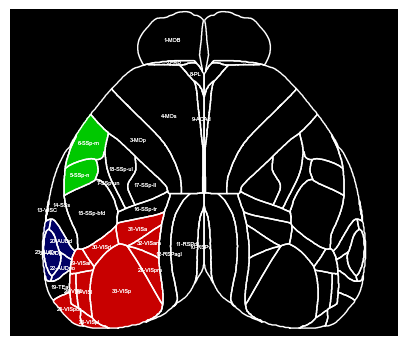

In [16]:
# Plot the overlap for the same region in the warped versus unwarped atlases 
bg = 0
aud=range(20,24)
soma = [5,6]
visual = range(24,34)

plt.figure(figsize = [5,5])
reg = np.zeros([*atlas.shape,3])
reg[:, :, 0] = np.isin(atlas, visual) * 200
reg[:, :, 1] = np.isin(atlas, soma) * 200
reg[:, :, 2] = np.isin(atlas, aud) * 100
plt.imshow(reg.astype('uint8'))

for i,r in ccf_regions.iterrows():
    for side in ['left', 'right']:
        plt.plot(np.array(r[side+'_x']),r[side +'_y'],'w',lw=1)
        plt.text(r.left_center[0], r.left_center[1], str(i+1)+'-'+r.acronym, color='w', va='center', fontsize=4, alpha=1, ha='center')
plt.axis('off')
# plt.savefig('/home/lzx/data/WF_VC_liuzhaoxi/______________natural_movie_summary/brain areas.png')
plt.show()

## summary SNR

In [17]:

path_snr_ls = glob(pjoin(f'Y:/WF_VC_liuzhaoxi/*/{stim}/process', '*-natural-movie--', '*snr_warped.npy'))
print(f'{len(path_snr_ls)} snr_warped.npy\n\n'+'\n'.join(path_snr_ls))


17 snr_warped.npy

Y:/WF_VC_liuzhaoxi\24.12.19_P41\natural-movie\process\20241219-192319-natural-movie--\P41_20241219-192319_snr_warped.npy
Y:/WF_VC_liuzhaoxi\24.12.19_P41\natural-movie-invert\process\20241219-201009-natural-movie--\P41_20241219-201009_snr_warped.npy
Y:/WF_VC_liuzhaoxi\24.12.19_P41\natural-movie-reverse\process\20241219-210558-natural-movie--\P41_20241219-210558_snr_warped.npy
Y:/WF_VC_liuzhaoxi\25.01.10_P41\natural-movie\process\20250110-013702-natural-movie--\P41_20250110-013702_snr_warped.npy
Y:/WF_VC_liuzhaoxi\25.01.10_P41\natural-movie-invert\process\20250110-020719-natural-movie--\P41_20250110-020719_snr_warped.npy
Y:/WF_VC_liuzhaoxi\25.01.10_U27\natural-movie\process\20250111-001641-natural-movie--\U27_20250111-001641_snr_warped.npy
Y:/WF_VC_liuzhaoxi\25.01.10_U27\natural-movie-invert\process\20250111-005054-natural-movie--\U27_20250111-005054_snr_warped.npy
Y:/WF_VC_liuzhaoxi\25.01.10_U27\natural-movie-reverse\process\20250110-233559-natural-movie--\U27_2025011

In [18]:
## cal all snr

snr_list = [np.load(path_snr) for path_snr in path_snr_ls]
snr_array = np.asarray(snr_list)
print('snr_array.shape', snr_array.shape)
np.save(pjoin(path_summary,'all_snr.npy'), snr_array)

n_experiment, warped_height, warped_width, n_movie = snr_array.shape


snr_array.shape (17, 540, 640, 14)


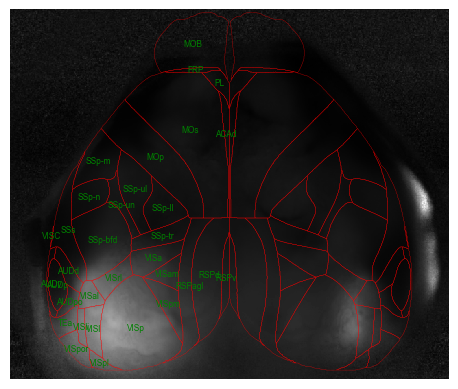

In [80]:
# plot warped avg_frame & CCF

fig = plt.figure()
plt.imshow(snr_array[0,:,:,8], cmap='gray')
# plt.imshow(brain_mask, cmap='gray')

for i, r in ccf_regions.iterrows():
    plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
    plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
    plt.text(r.left_center[0], r.left_center[1], r.acronym, color='g', va='center', fontsize=6, alpha=1, ha='center')

plt.axis('off')
fig.set_facecolor('white')
plt.show()

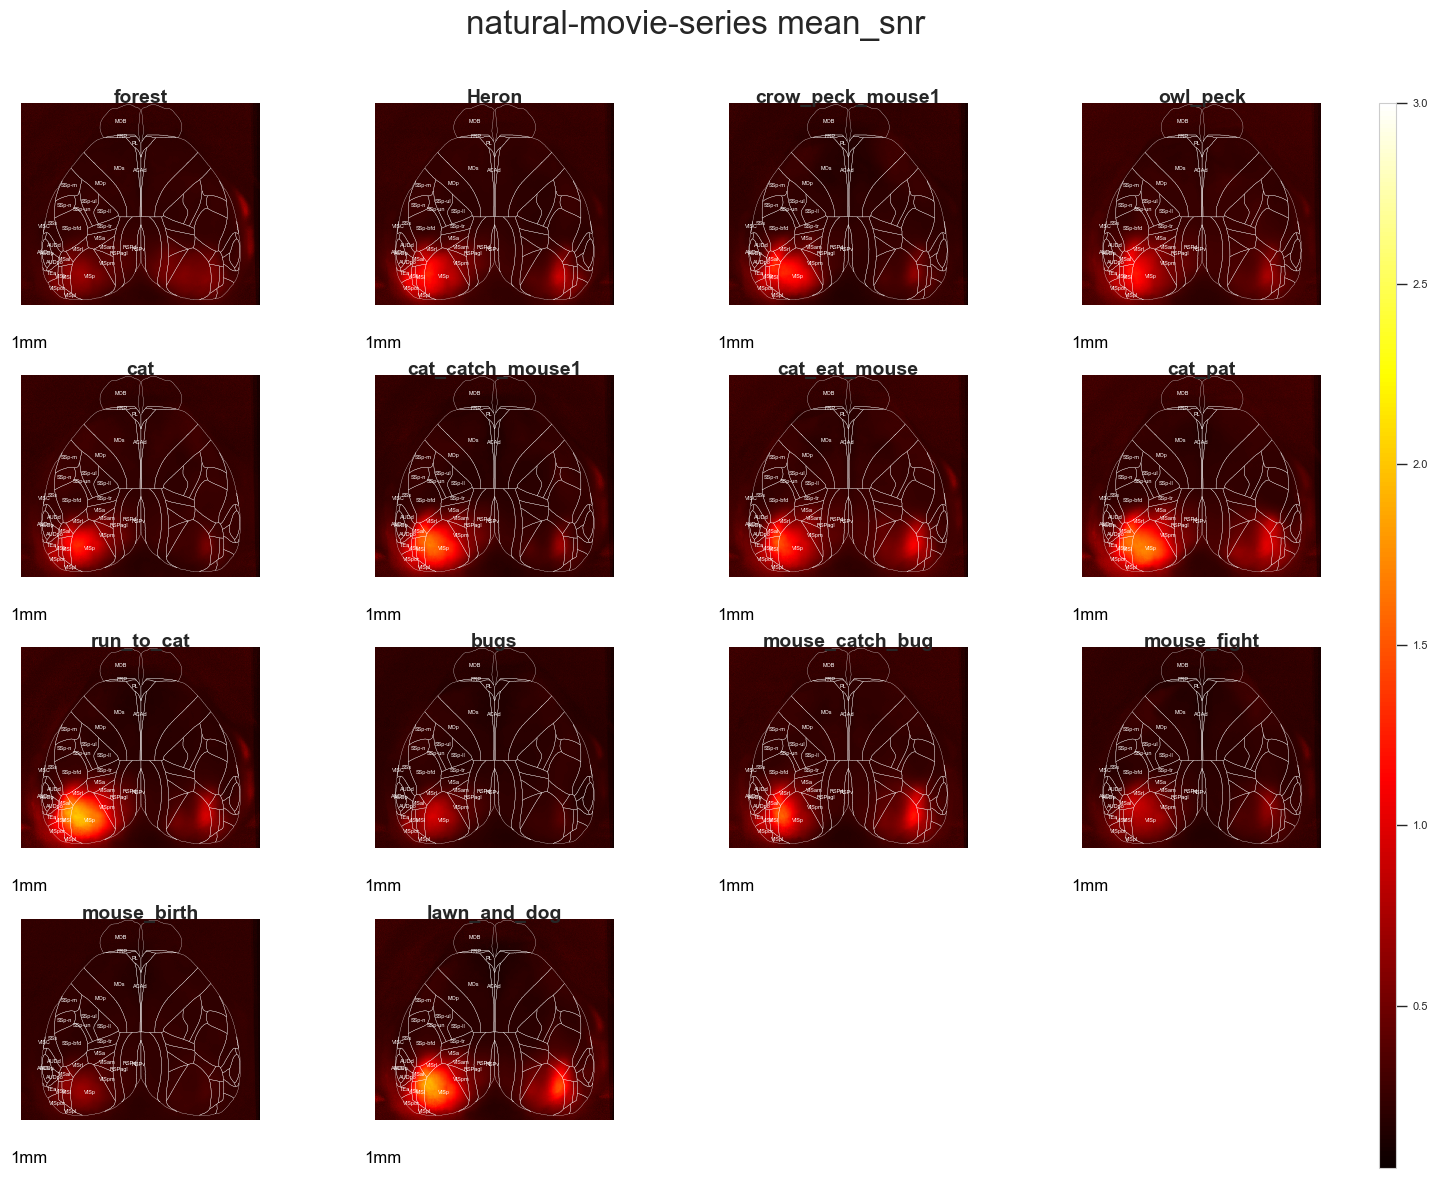

In [19]:
subplot_movie_heatmap(snr_array.mean(axis=0), 4, 4, movie_name_list, path_outfile=pjoin(path_summary, 'mean_snr.png'),
                      title='mean_snr', vmax=3, pixel_um=26, patches=None,
                      ccf_regions=ccf_regions)

In [20]:
def flat_mask_warped(Uflat,xy):
    # index are in xy, like what np.where(mask) returns
    x = np.array(np.clip(xy[0],0,warped_height-1),dtype=int)
    y = np.array(np.clip(xy[1],0,warped_width-1),dtype=int)
    idx = np.ravel_multi_index((x,y),(warped_height, warped_width))
    t = Uflat[idx,:]
    return t

snr_array_flat= snr_array.transpose(1,2,0,3).reshape(warped_height*warped_width, n_experiment*n_movie)
all_area_snr =np.empty((33, snr_array_flat.shape[-1]))

for area in range(1,34):
    all_area_snr[area-1] = flat_mask_warped(snr_array_flat, np.where(atlas == area)).mean(axis=0)
all_area_snr = all_area_snr.reshape(33, n_experiment, n_movie)

np.save(pjoin(path_summary, 'all_area_snr.npy'), all_area_snr)

In [21]:
all_area_snr = np.load(pjoin(path_summary, 'all_area_snr.npy'))

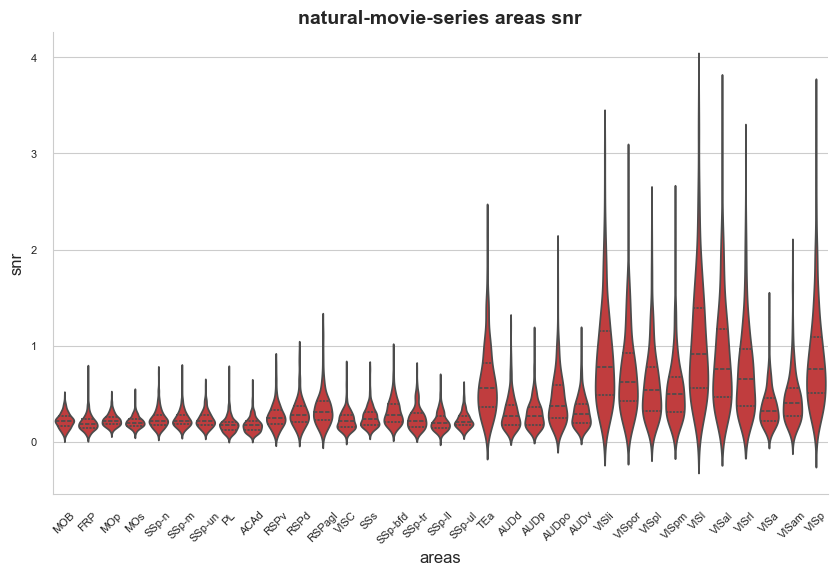

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 将矩阵转换为 DataFrame
df = pd.DataFrame(all_area_snr.reshape(33, -1).T, columns=area_list)

# 将数据转换为长格式
df_long = df.melt(var_name='areas', value_name='snr')

# 按每组的平均值对分组排序
group_order = df.mean(axis=0).sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
# sns.boxplot(x='areas', y='snr', data=df_long, order=group_order)
# sns.violinplot(x='areas', y='snr', data=df_long, order=group_order, scale='width', inner='quartile')   # 绘制小提琴图
sns.violinplot(x='areas', y='snr', data=df_long, order=None, density_norm='width', inner='quartile', color='tab:red')   # 绘制小提琴图
plt.title('areas snr')
plt.xlabel('areas')
plt.ylabel('snr')
plt.xticks(rotation=45)
fig = plt.gcf()  # 获取当前图形对象
fig.set_facecolor('white')  # 设置背景为白色
# plt.savefig(pjoin(path_summary, 'all areas snr rank.png'), facecolor='white', transparent=False)
plt.savefig(pjoin(path_summary, 'all areas snr.png'), facecolor='white', transparent=False)
plt.show()


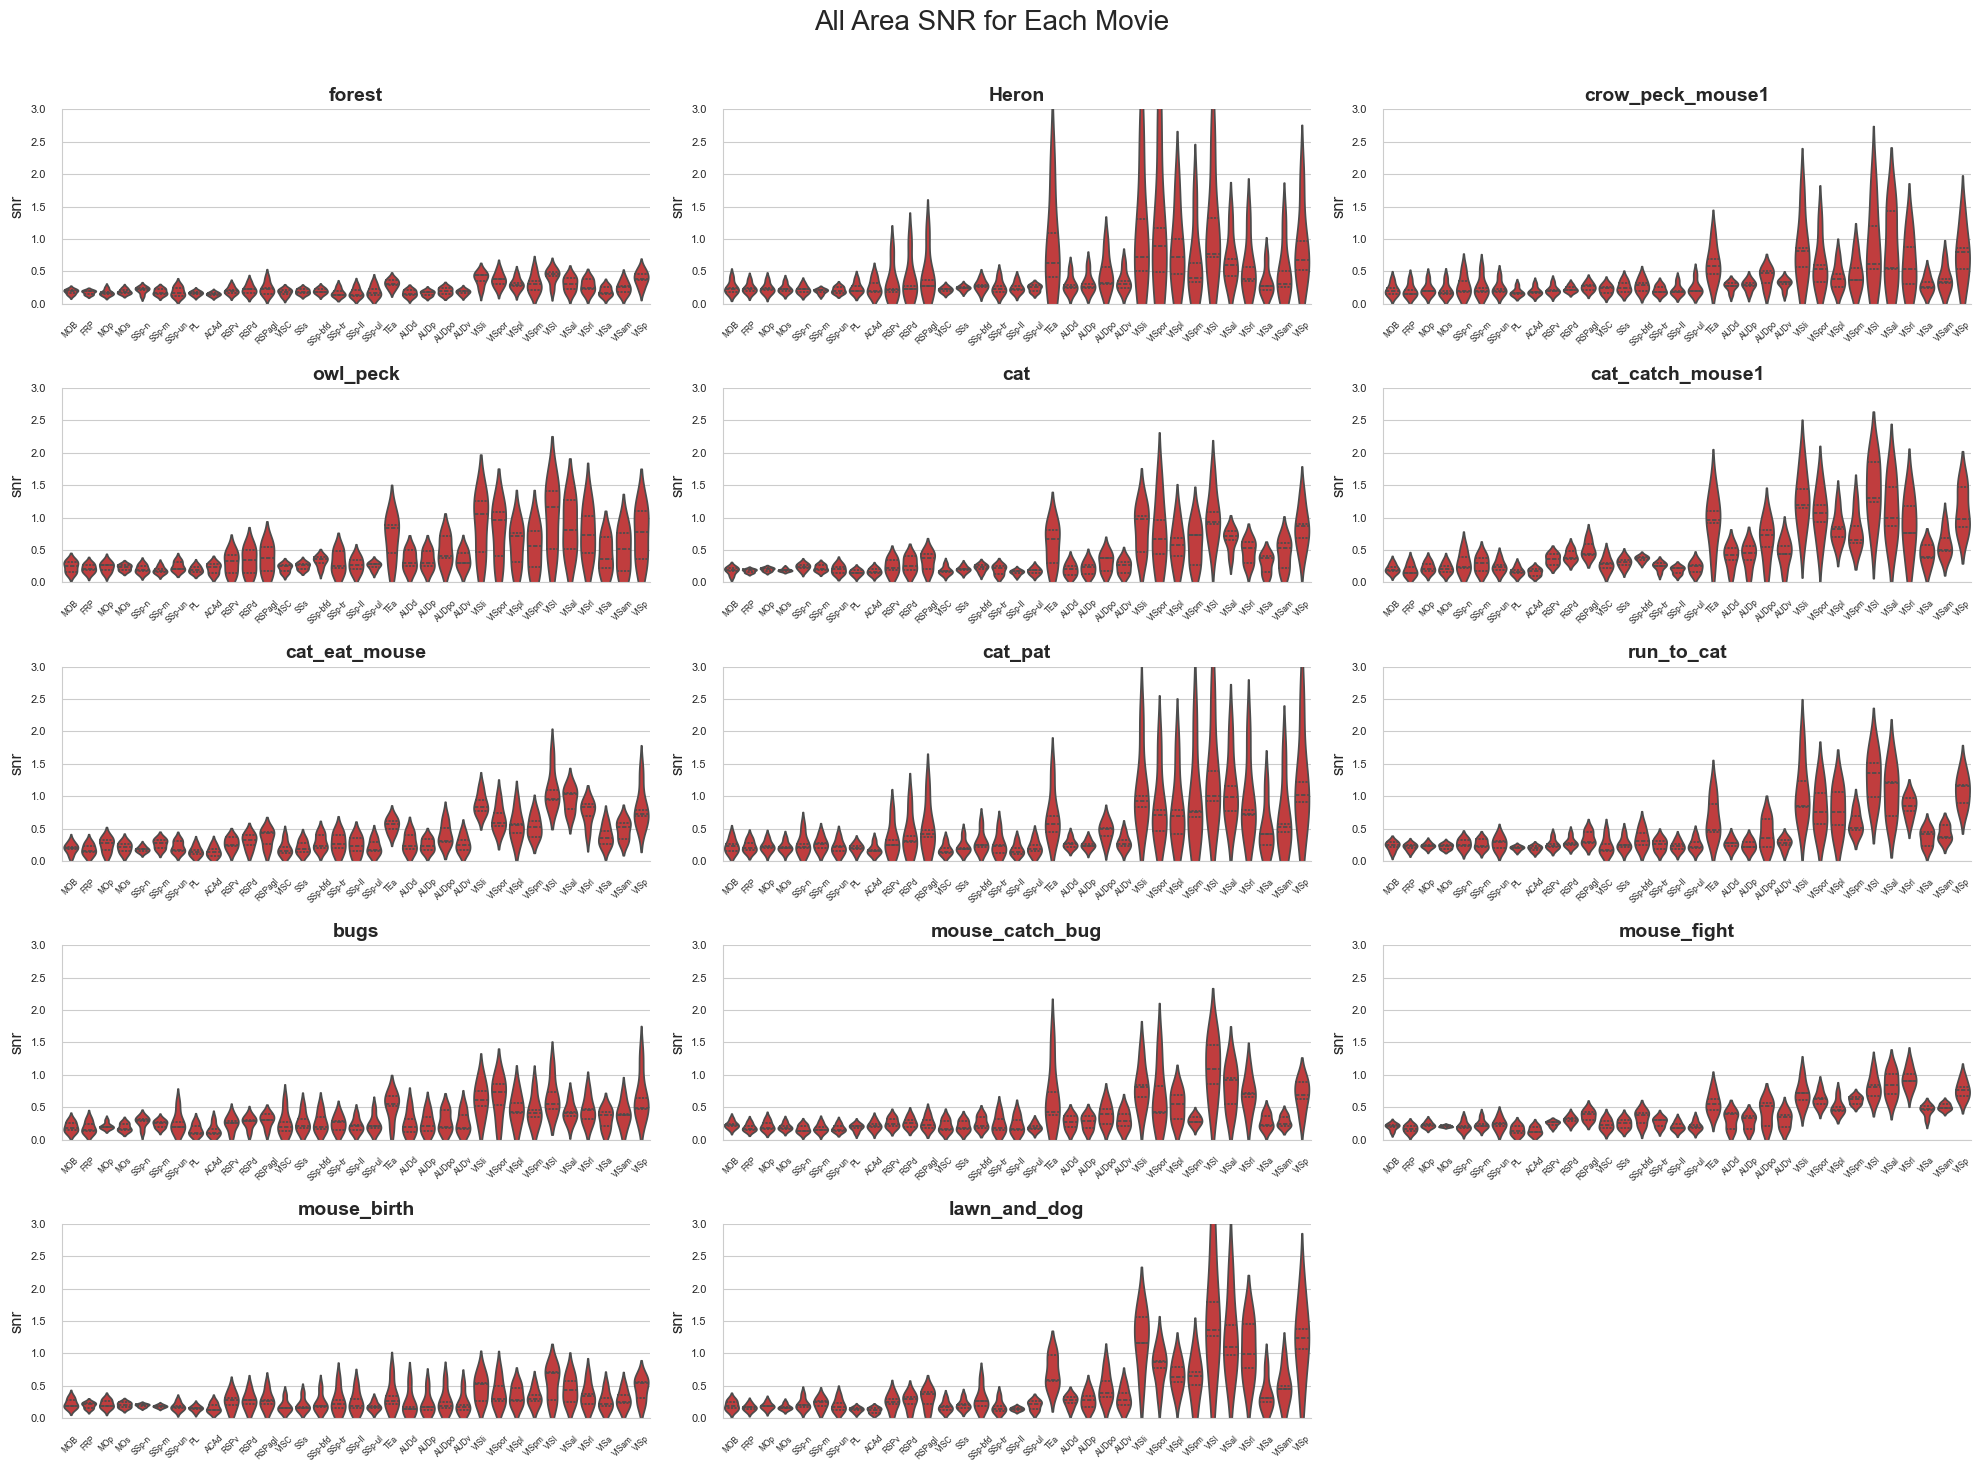

In [85]:
# 创建子图
fig, axes = plt.subplots(5, 3, figsize=(20, 15))
axes = axes.flatten()  # 将 axes 二维数组展平，便于迭代
for i in range(n_movie):  # 遍历第三维的每个小图
    # 提取当前小图对应的数据
    matrix = all_area_snr[:, :, i]
    df = pd.DataFrame(matrix.T, columns=area_list)
    
    # 转换为长格式
    df_long = df.melt(var_name='areas', value_name='snr')

    # sns.boxplot(x='areas', y='snr', data=df_long, order=None, ax=axes[i])
    sns.violinplot(x='areas', y='snr', data=df_long, order=None, ax=axes[i], density_norm='width', inner='quartile', color='tab:red')     # 绘制小提琴图
    axes[i].set_title(movie_name_list[i])  # 设置小标题
    axes[i].set_xlabel('')  # 隐藏 x 轴标签以节省空间
    axes[i].set_ylabel('snr')
    axes[i].set_ylim(0, 3)  # 设置统一 y 轴范围
    axes[i].tick_params(axis='x', rotation=45, labelsize=6)  # 调整刻度角度和字体大小
    # for label in axes[i].get_xticklabels():
    #     label.set_ha('right')  # 设置 x 轴标签右对齐

# 删除多余的子图（仅 14 个小图）
for j in range(14, len(axes)):
    fig.delaxes(axes[j])

# 设置整体标题和布局
fig.suptitle('All Area SNR for Each Movie', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.set_facecolor('white')  # 设置背景为白色

# 保存图像
plt.savefig(pjoin(path_summary, 'all_areas_snr_per_movie_unified_y_violin.png'), facecolor='white', transparent=False)
plt.show()


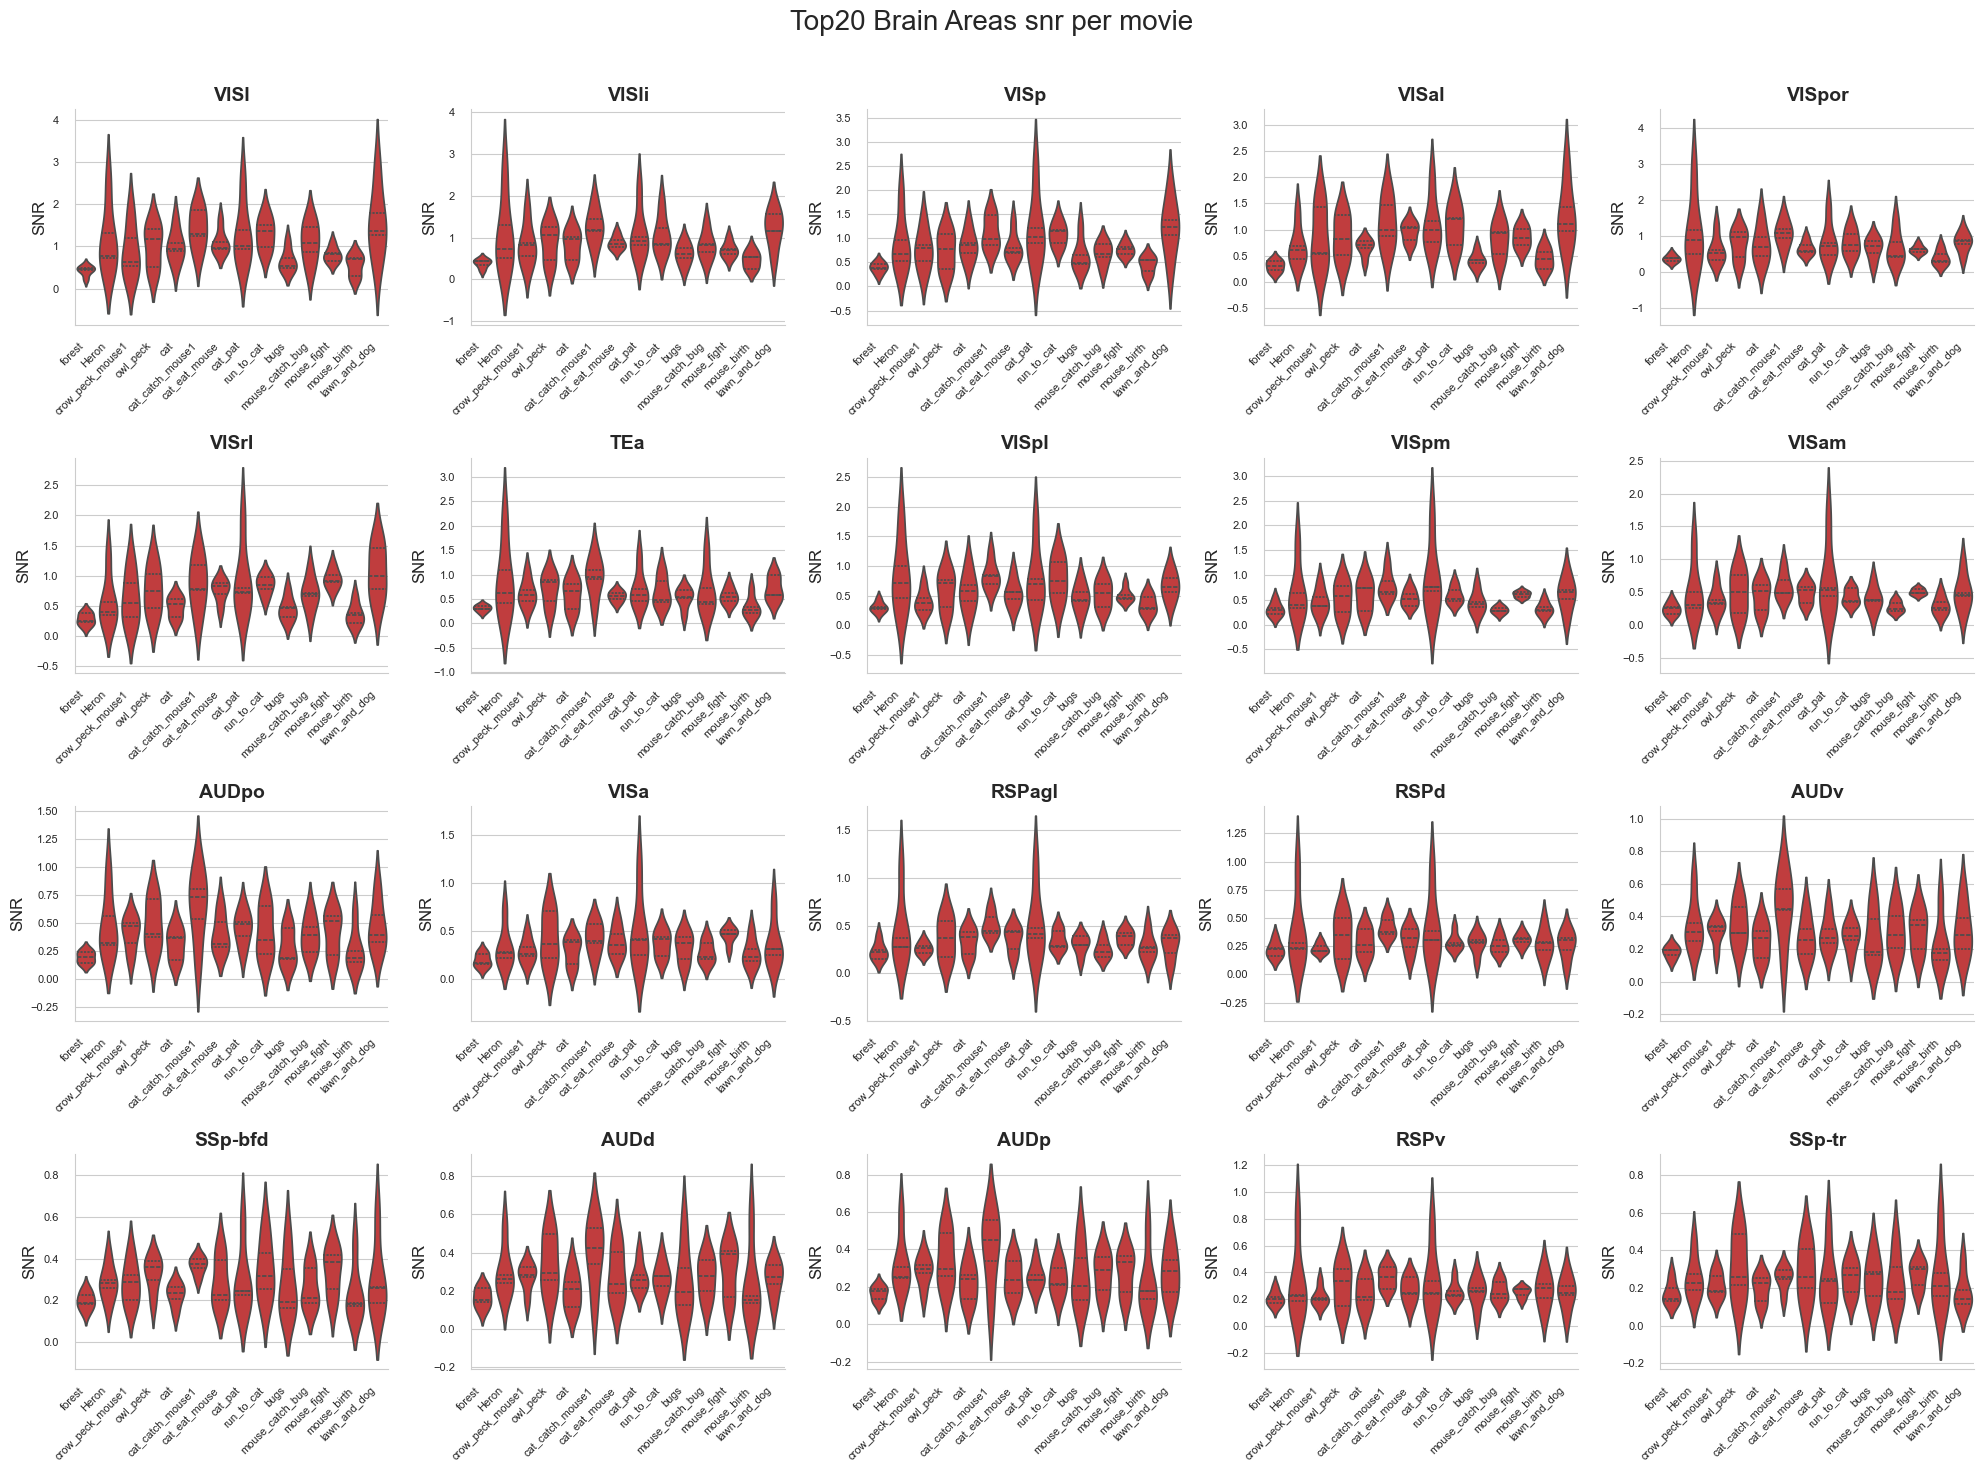

In [86]:

# 选出平均反应最强的 20 个脑区的索引
top_20_indices = np.argsort(all_area_snr.mean(axis=(1, 2)))[-20:][::-1]  # 从大到小排序取前 20
top_20_areas = [area_list[i] for i in top_20_indices]

# 创建子图
fig, axes = plt.subplots(4, 5, figsize=(20, 15))
axes = axes.flatten()  # 将子图展平成一维数组，方便迭代

for idx, area_idx in enumerate(top_20_indices):  # 遍历前 20 个脑区
    # 提取当前脑区的数据
    data = all_area_snr[area_idx, :, :]  # (重复数, 视频数)
    df = pd.DataFrame(data, columns=movie_name_list)  # 将视频作为列
    df_long = df.melt(var_name='Movies', value_name='SNR')  # 转为长格式
    
    # sns.boxplot(x='Movies', y='SNR', data=df_long, ax=axes[idx])
    sns.violinplot(x='Movies', y='SNR', data=df_long, ax=axes[idx], density_norm='width', inner='quartile', color='tab:red')      
    axes[idx].set_title(top_20_areas[idx])  # 设置小标题为脑区名
    axes[idx].set_xlabel('')  # 隐藏 x 轴标签
    axes[idx].set_ylabel('SNR')  # y 轴标签保持为 SNR
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)  # 设置刻度字体大小
    for label in axes[idx].get_xticklabels():
        label.set_ha('right')  # 设置 x 轴标签右对齐
        
# 删除多余的子图（如果脑区小于 20）
for j in range(len(top_20_indices), len(axes)):
    fig.delaxes(axes[j])

# 设置整体标题和布局
fig.suptitle('Top20 Brain Areas snr per movie', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.set_facecolor('white')  # 设置背景为白色

# 保存图像
plt.savefig(pjoin(path_summary, 'top20_areas_snr_per_movie.png'), facecolor='white', transparent=False)
plt.show()


## summary std

In [23]:
path_std_ls = glob(pjoin(f'Y:/WF_VC_liuzhaoxi/*/{stim}/process', '*-natural-movie--', '*std_warped.npy'))
print(f'{len(path_std_ls)} std_warped.npy\n\n'+'\n'.join(path_std_ls))

17 std_warped.npy

Y:/WF_VC_liuzhaoxi\24.12.19_P41\natural-movie\process\20241219-192319-natural-movie--\P41_20241219-192319_std_warped.npy
Y:/WF_VC_liuzhaoxi\24.12.19_P41\natural-movie-invert\process\20241219-201009-natural-movie--\P41_20241219-201009_std_warped.npy
Y:/WF_VC_liuzhaoxi\24.12.19_P41\natural-movie-reverse\process\20241219-210558-natural-movie--\P41_20241219-210558_std_warped.npy
Y:/WF_VC_liuzhaoxi\25.01.10_P41\natural-movie\process\20250110-013702-natural-movie--\P41_20250110-013702_std_warped.npy
Y:/WF_VC_liuzhaoxi\25.01.10_P41\natural-movie-invert\process\20250110-020719-natural-movie--\P41_20250110-020719_std_warped.npy
Y:/WF_VC_liuzhaoxi\25.01.10_U27\natural-movie\process\20250111-001641-natural-movie--\U27_20250111-001641_std_warped.npy
Y:/WF_VC_liuzhaoxi\25.01.10_U27\natural-movie-invert\process\20250111-005054-natural-movie--\U27_20250111-005054_std_warped.npy
Y:/WF_VC_liuzhaoxi\25.01.10_U27\natural-movie-reverse\process\20250110-233559-natural-movie--\U27_2025011

In [24]:
## cal all std

std_list = [np.load(path_std) for path_std in path_std_ls]
std_array = np.asarray(std_list)
print('std_array.shape', std_array.shape)

np.save(pjoin(path_summary,'all_std.npy'), std_array)

std_array.shape (17, 540, 640, 14)


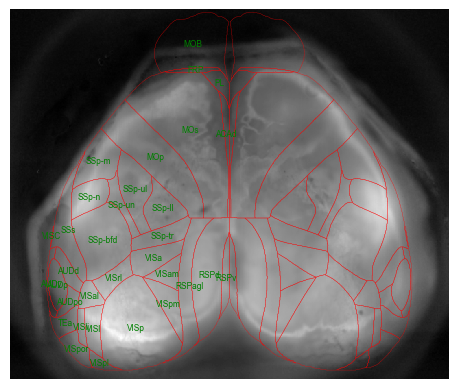

In [89]:
# plot warped avg_frame & CCF

fig = plt.figure()
plt.imshow(std_array[0, :, :, 8], cmap='gray')  # 将 snr_array 替换为 std_array
# plt.imshow(brain_mask, cmap='gray')

for i, r in ccf_regions.iterrows():
    plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
    plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
    plt.text(r.left_center[0], r.left_center[1], r.acronym, color='g', va='center', fontsize=6, alpha=1, ha='center')

plt.axis('off')
fig.set_facecolor('white')
plt.show()



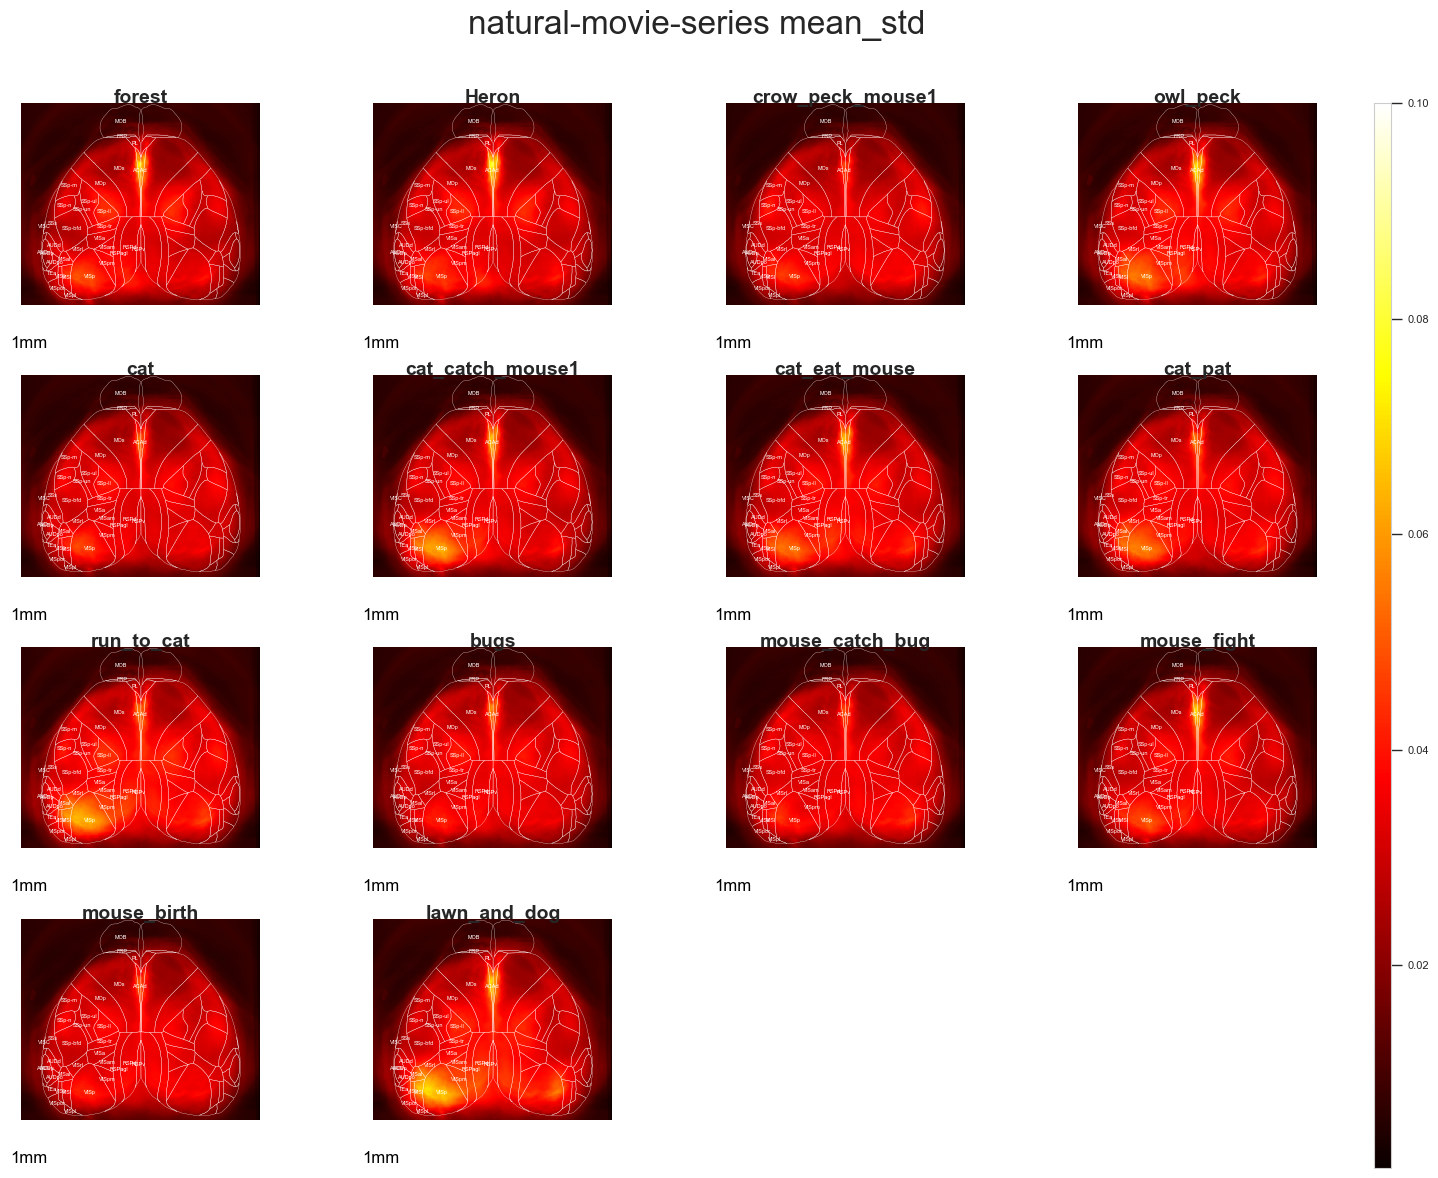

In [25]:

subplot_movie_heatmap(std_array.mean(axis=0), 4, 4, movie_name_list, path_outfile=pjoin(path_summary, 'mean_std.png'),
                      title='mean_std', vmax=0.1, pixel_um=26, patches=None,
                      ccf_regions=ccf_regions)



In [26]:
def flat_mask_warped(Uflat,xy):
    # index are in xy, like what np.where(mask) returns
    x = np.array(np.clip(xy[0],0,warped_height-1),dtype=int)
    y = np.array(np.clip(xy[1],0,warped_width-1),dtype=int)
    idx = np.ravel_multi_index((x,y),(warped_height, warped_width))
    t = Uflat[idx,:]
    return t

std_array_flat= std_array.transpose(1,2,0,3).reshape(warped_height*warped_width, n_experiment*n_movie)
all_area_std =np.empty((33, std_array_flat.shape[-1]))

for area in range(1,34):
    all_area_std[area-1] = flat_mask_warped(std_array_flat, np.where(atlas == area)).mean(axis=0)
all_area_std = all_area_std.reshape(33, n_experiment, n_movie)

np.save(pjoin(path_summary, 'all_area_std.npy'), all_area_std)

In [27]:

all_area_std = np.load(pjoin(path_summary, 'all_area_std.npy'))  


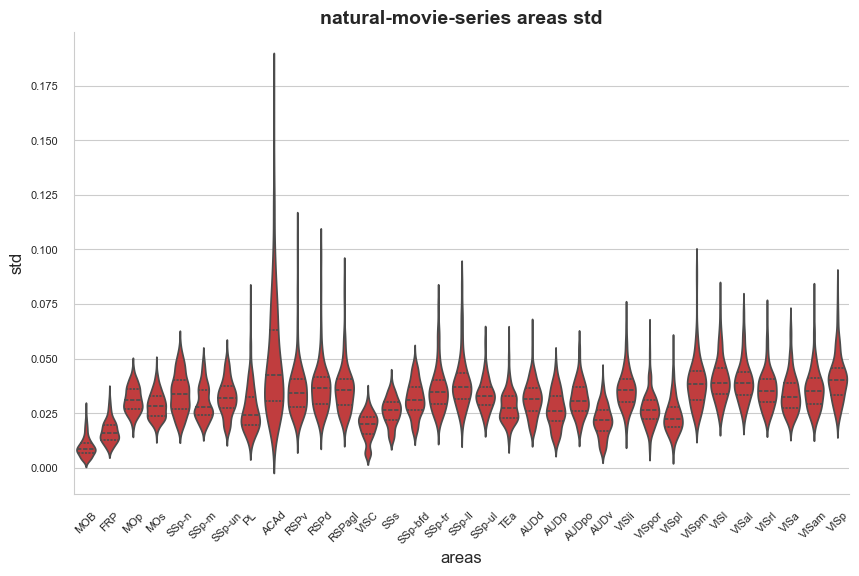

In [28]:

# 将矩阵转换为 DataFrame
df = pd.DataFrame(all_area_std.reshape(33, -1).T, columns=area_list)

# 将数据转换为长格式
df_long = df.melt(var_name='areas', value_name='std')

# 按每组的平均值对分组排序
group_order = df.mean(axis=0).sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
# sns.boxplot(x='areas', y='std', data=df_long, order=group_order)
# sns.violinplot(x='areas', y='std', data=df_long, order=group_order, scale='width', inner='quartile')   # 绘制小提琴图
sns.violinplot(x='areas', y='std', data=df_long, order=None, density_norm='width', inner='quartile', color='tab:red')   # 绘制小提琴图
plt.title('areas std')
plt.xlabel('areas')
plt.ylabel('std')
plt.xticks(rotation=45)
fig = plt.gcf()  # 获取当前图形对象
fig.set_facecolor('white')  # 设置背景为白色
# plt.savefig(pjoin(path_summary, 'all areas std rank.png'), facecolor='white', transparent=False)
plt.savefig(pjoin(path_summary, 'all areas std.png'), facecolor='white', transparent=False)
plt.show()


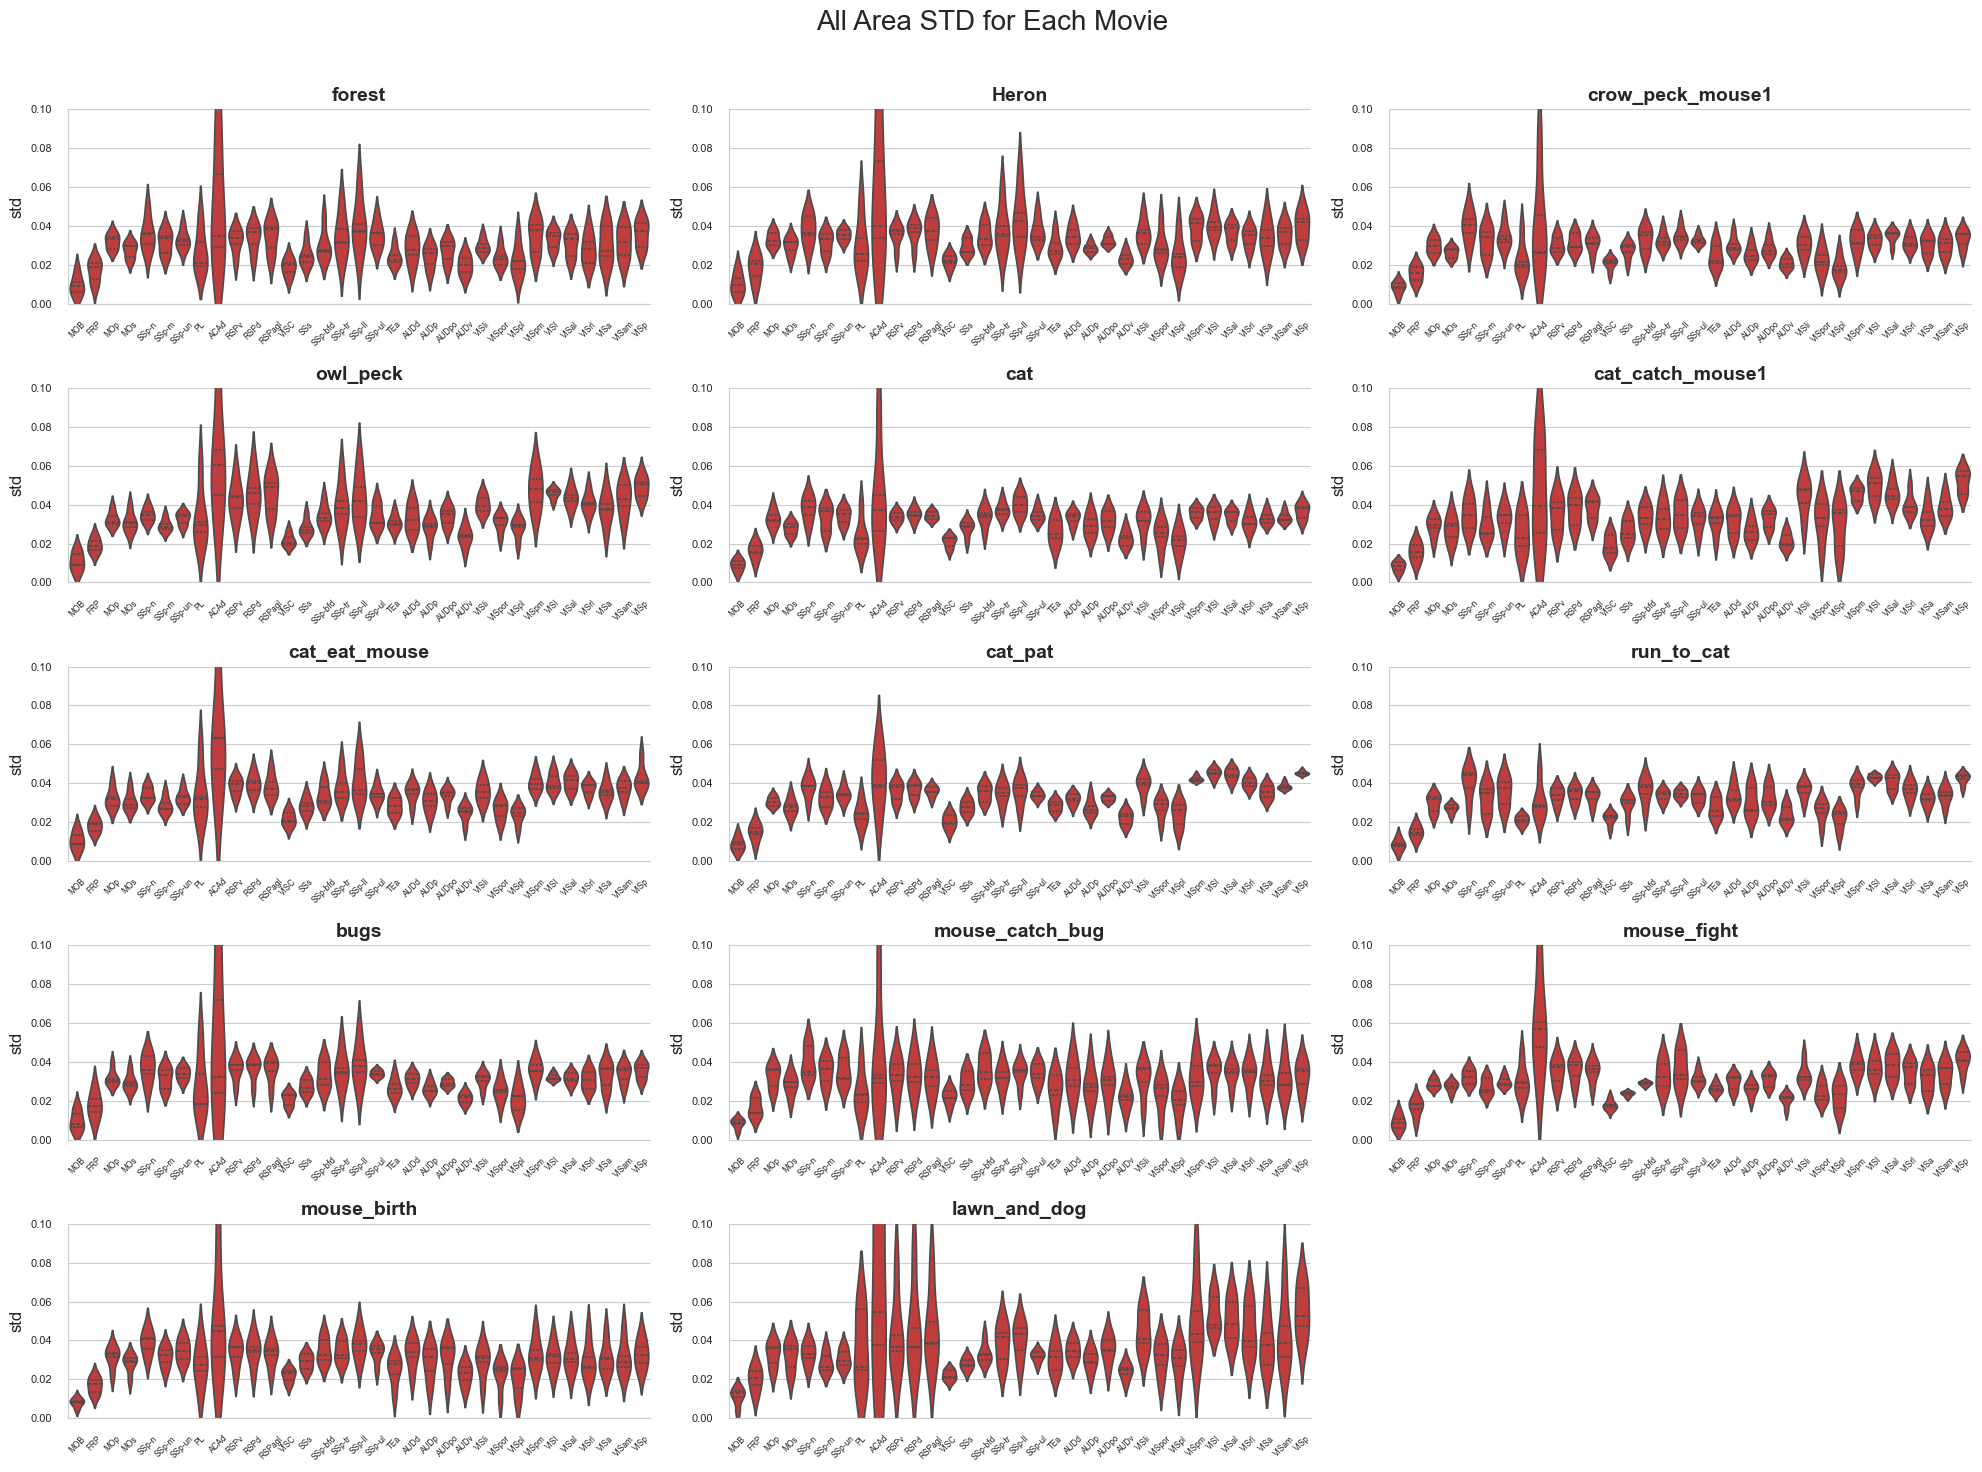

In [94]:


# 创建子图
fig, axes = plt.subplots(5, 3, figsize=(20, 15))
axes = axes.flatten()  # 将 axes 二维数组展平，便于迭代
for i in range(n_movie):  # 遍历第三维的每个小图
    # 提取当前小图对应的数据
    matrix = all_area_std[:, :, i]  # 替换 all_area_snr 为 all_area_std
    df = pd.DataFrame(matrix.T, columns=area_list)
    
    # 转换为长格式
    df_long = df.melt(var_name='areas', value_name='std')

    # sns.boxplot(x='areas', y='std', data=df_long, order=None, ax=axes[i])
    sns.violinplot(x='areas', y='std', data=df_long, order=None, ax=axes[i], density_norm='width', inner='quartile', color='tab:red')  
    axes[i].set_title(movie_name_list[i])  # 设置小标题
    axes[i].set_xlabel('')  # 隐藏 x 轴标签以节省空间
    axes[i].set_ylabel('std')  
    axes[i].set_ylim(0, 0.1)  # 设置统一 y 轴范围
    axes[i].tick_params(axis='x', rotation=45, labelsize=6)  # 调整刻度角度和字体大小

# 删除多余的子图（仅 14 个小图）
for j in range(14, len(axes)):
    fig.delaxes(axes[j])

# 设置整体标题和布局
fig.suptitle('All Area STD for Each Movie', fontsize=20)  # 替换标题中的 SNR 为 STD
fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.set_facecolor('white')  # 设置背景为白色

# 保存图像
plt.savefig(pjoin(path_summary, 'all_areas_std_per_movie_unified_y_violin.png'), facecolor='white', transparent=False)  # 替换文件名
plt.show()



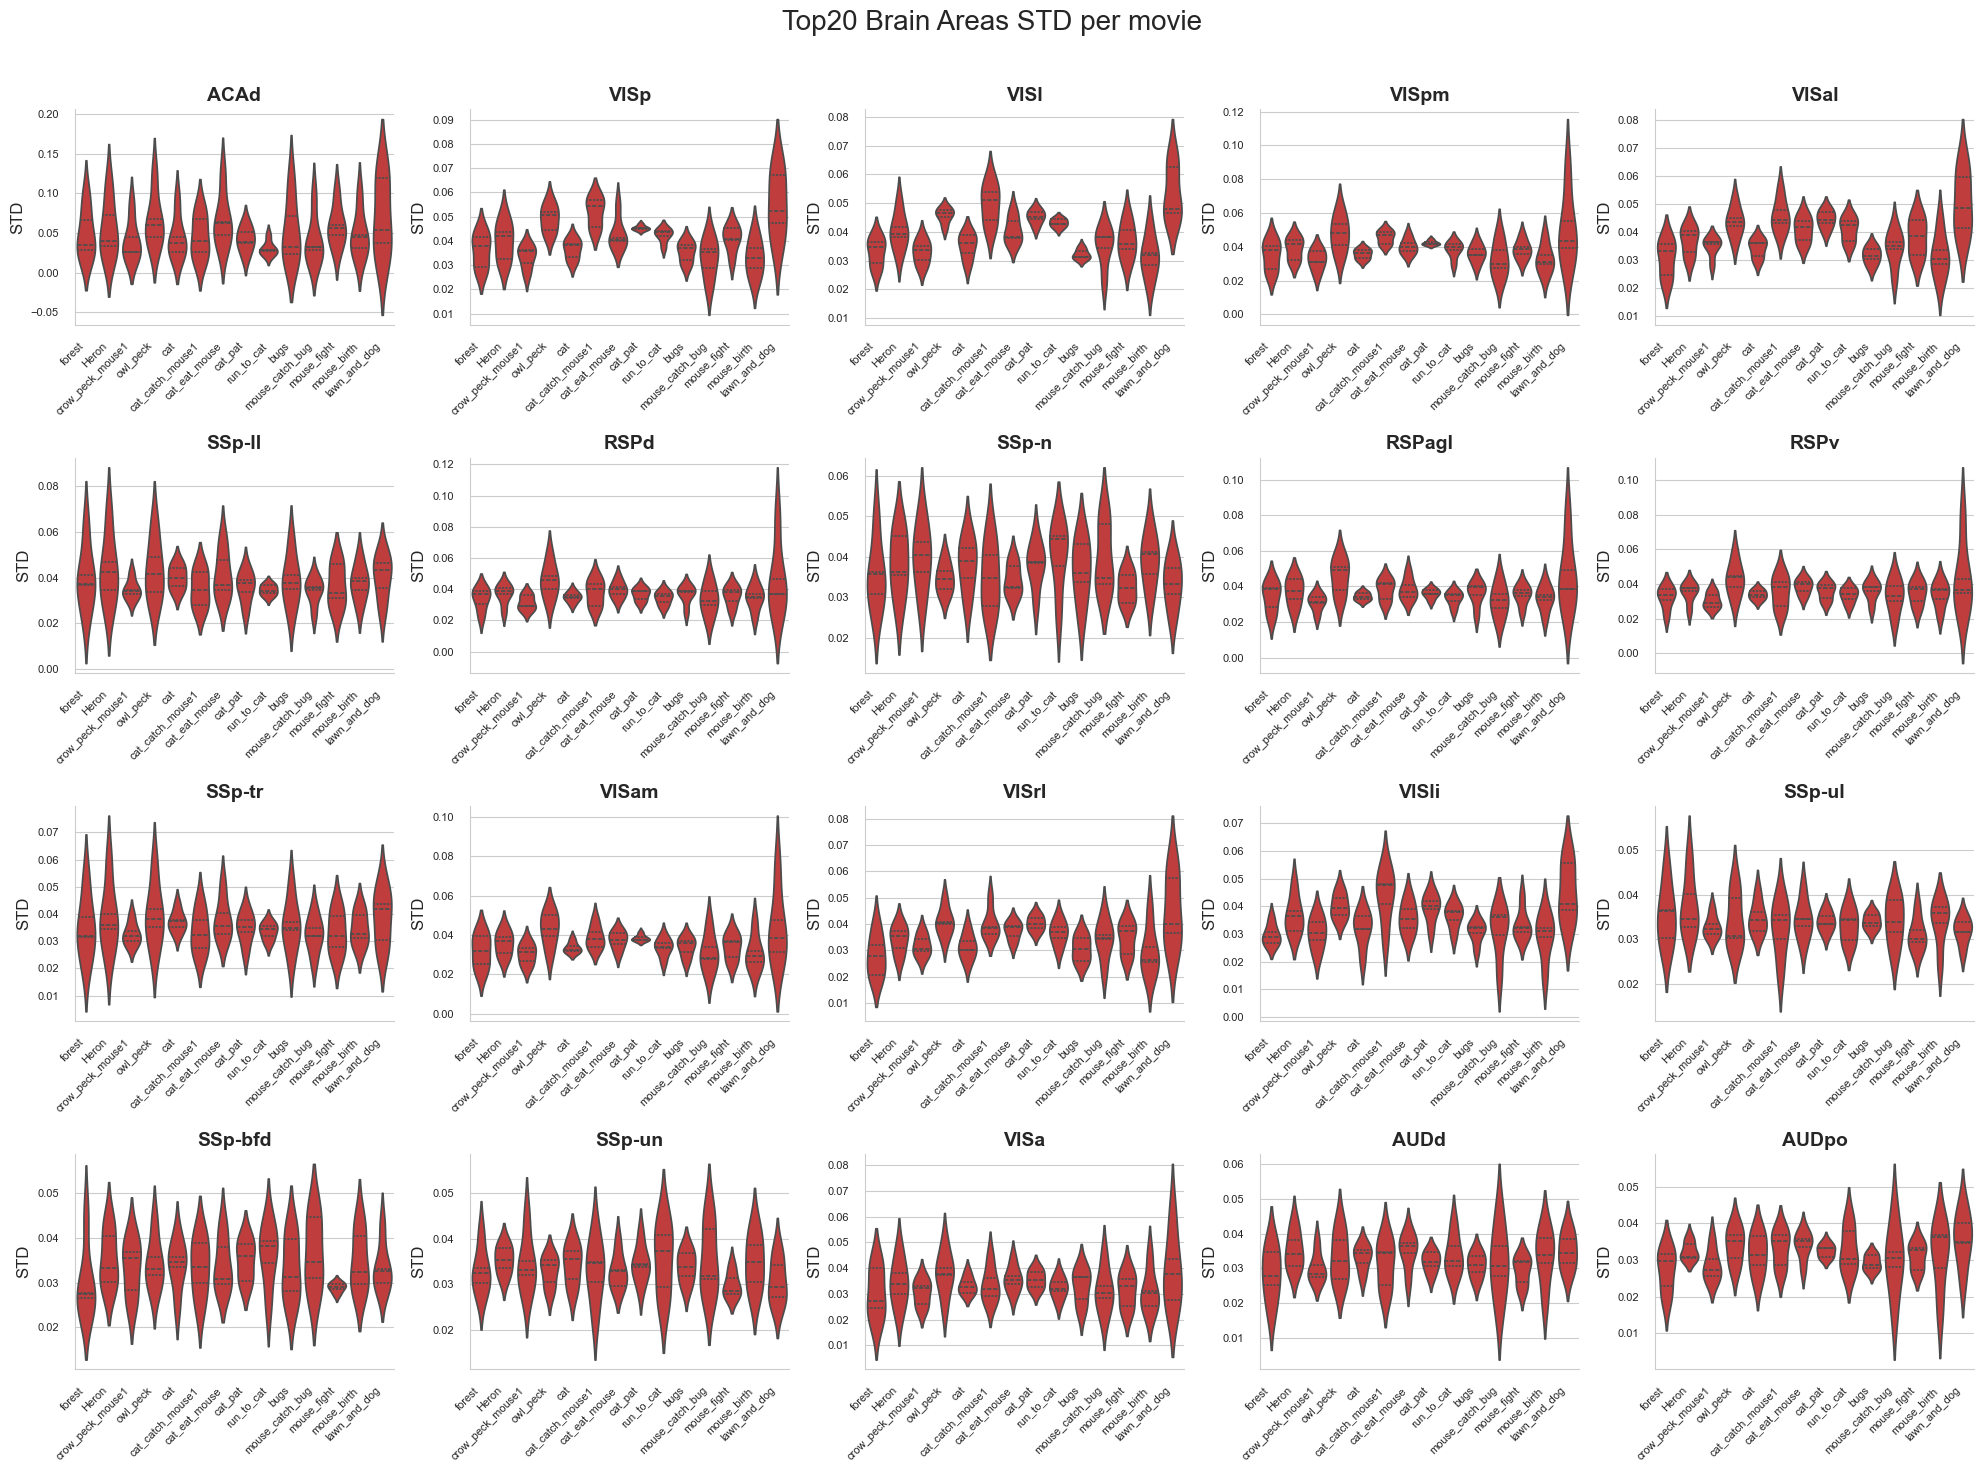

In [95]:

# 选出平均反应最强的 20 个脑区的索引
top_20_indices = np.argsort(all_area_std.mean(axis=(1, 2)))[-20:][::-1]  # 替换 all_area_snr 为 all_area_std
top_20_areas = [area_list[i] for i in top_20_indices]

# 创建子图
fig, axes = plt.subplots(4, 5, figsize=(20, 15))
axes = axes.flatten()  # 将子图展平成一维数组，方便迭代

for idx, area_idx in enumerate(top_20_indices):  # 遍历前 20 个脑区
    # 提取当前脑区的数据
    data = all_area_std[area_idx, :, :]  # 替换 all_area_snr 为 all_area_std
    df = pd.DataFrame(data, columns=movie_name_list)  # 将视频作为列
    df_long = df.melt(var_name='Movies', value_name='STD')  # 替换 SNR 为 STD
    
    # sns.boxplot(x='Movies', y='STD', data=df_long, ax=axes[idx])
    sns.violinplot(x='Movies', y='STD', data=df_long, ax=axes[idx], density_norm='width', inner='quartile', color='tab:red')  # 替换 y='SNR' 为 y='STD'
    axes[idx].set_title(top_20_areas[idx])  # 设置小标题为脑区名
    axes[idx].set_xlabel('')  # 隐藏 x 轴标签
    axes[idx].set_ylabel('STD')  # 替换 y 轴标签为 STD
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)  # 设置刻度字体大小
    for label in axes[idx].get_xticklabels():
        label.set_ha('right')  # 设置 x 轴标签右对齐

# 删除多余的子图（如果脑区小于 20）
for j in range(len(top_20_indices), len(axes)):
    fig.delaxes(axes[j])

# 设置整体标题和布局
fig.suptitle('Top20 Brain Areas STD per movie', fontsize=20)  # 替换标题中的 SNR 为 STD
fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.set_facecolor('white')  # 设置背景为白色

# 保存图像
plt.savefig(pjoin(path_summary, 'top20_areas_std_per_movie.png'), facecolor='white', transparent=False)  # 替换文件名
plt.show()


## summary area correlation

In [29]:
path_correlation_ls = glob(pjoin(f'Y:/WF_VC_liuzhaoxi/*/{stim}/process', '*-natural-movie--', '*all area correlation.npy'))
print(f'{len(path_correlation_ls)} all_area_correlation.npy\n\n'+'\n'.join(path_correlation_ls))


17 all_area_correlation.npy

Y:/WF_VC_liuzhaoxi\24.12.19_P41\natural-movie\process\20241219-192319-natural-movie--\P41_20241219-192319_all area correlation.npy
Y:/WF_VC_liuzhaoxi\24.12.19_P41\natural-movie-invert\process\20241219-201009-natural-movie--\P41_20241219-201009_all area correlation.npy
Y:/WF_VC_liuzhaoxi\24.12.19_P41\natural-movie-reverse\process\20241219-210558-natural-movie--\P41_20241219-210558_all area correlation.npy
Y:/WF_VC_liuzhaoxi\25.01.10_P41\natural-movie\process\20250110-013702-natural-movie--\P41_20250110-013702_all area correlation.npy
Y:/WF_VC_liuzhaoxi\25.01.10_P41\natural-movie-invert\process\20250110-020719-natural-movie--\P41_20250110-020719_all area correlation.npy
Y:/WF_VC_liuzhaoxi\25.01.10_U27\natural-movie\process\20250111-001641-natural-movie--\U27_20250111-001641_all area correlation.npy
Y:/WF_VC_liuzhaoxi\25.01.10_U27\natural-movie-invert\process\20250111-005054-natural-movie--\U27_20250111-005054_all area correlation.npy
Y:/WF_VC_liuzhaoxi\25.01.

In [30]:
correlation_list = [np.load(path_correlation) for path_correlation in path_correlation_ls]
correlation_array = np.asarray(correlation_list)
print('correlation_array.shape', correlation_array.shape)

np.save(pjoin(path_summary,'all_area_correlation.npy'), correlation_array)

correlation_array.shape (17, 33, 33)


In [31]:
area_list1 = ['MOB','FRP','MOp','MOs','PL','ACAd','RSPv','RSPd','RSPagl','VISC',
             'SSp-n','SSp-m','SSp-un','SSs','SSp-bfd','SSp-tr','SSp-ll','SSp-ul','TEa','AUDd','AUDp','AUDpo','AUDv',
             'VISli','VISpor','VISpl','VISpm','VISl','VISal','VISrl','VISa','VISam','VISp']

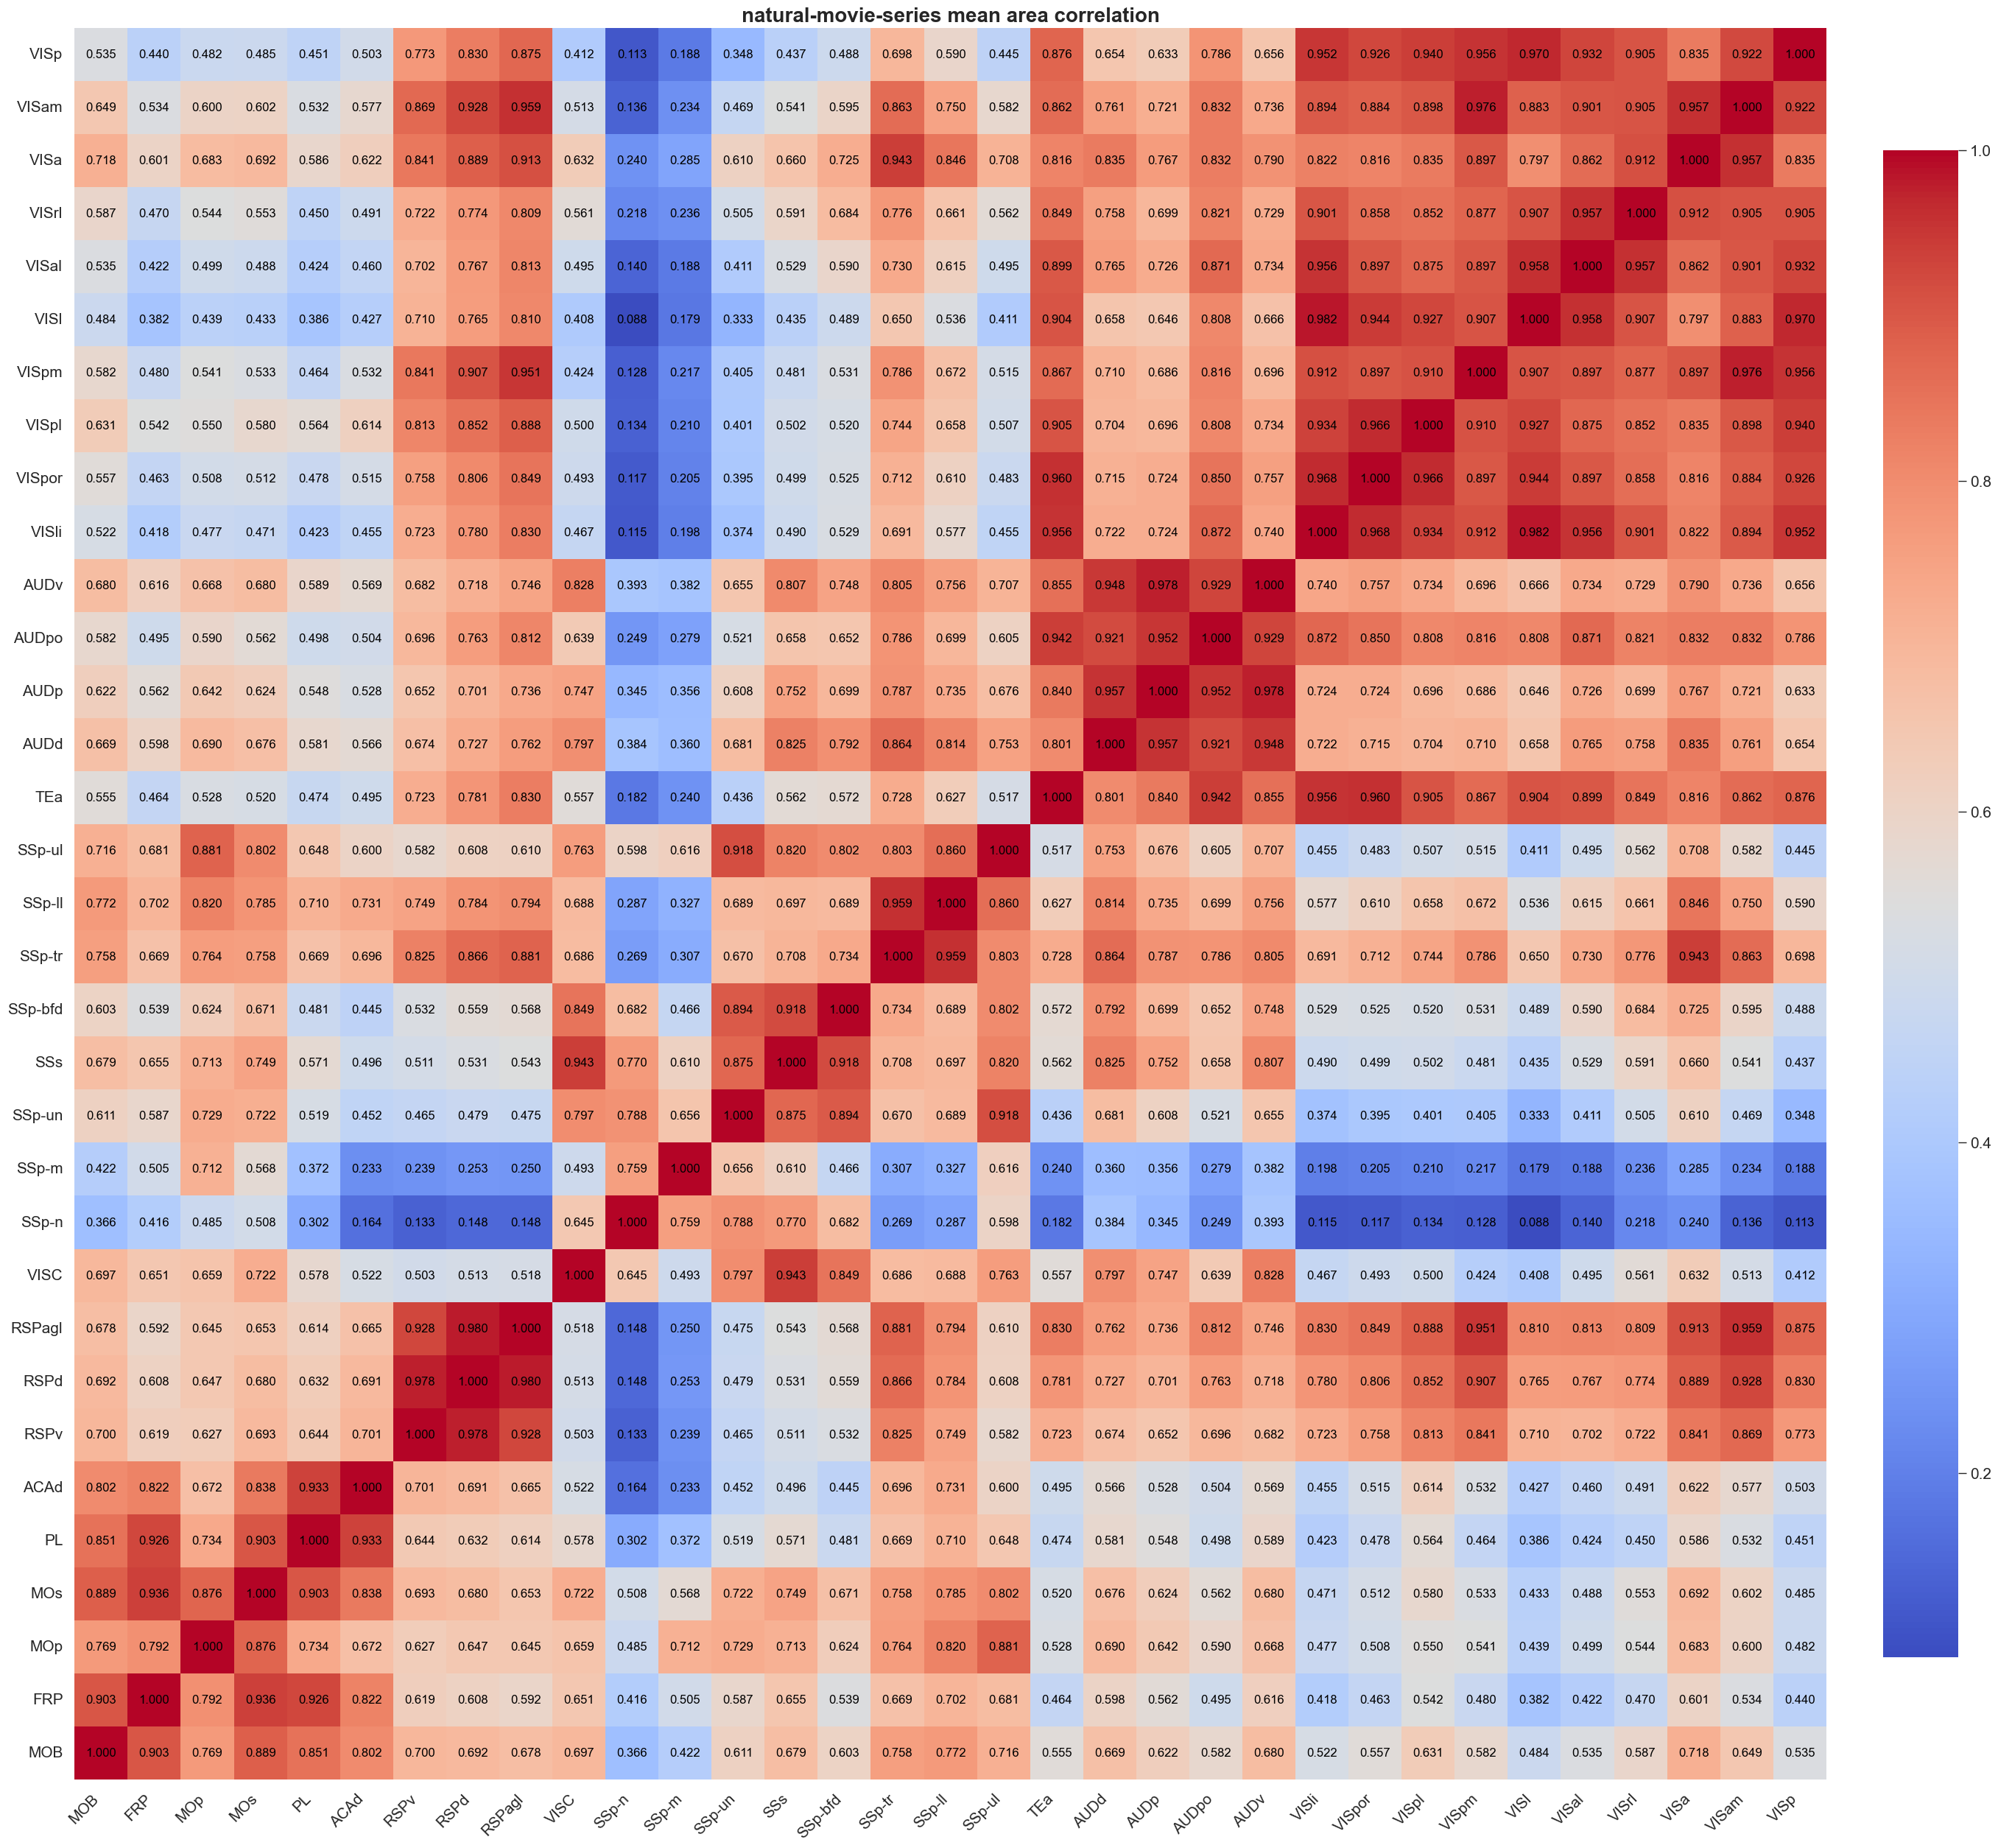

In [32]:
plot_heatmap(correlation_array.mean(axis=0), xlabel=area_list1, ylabel=area_list1, cmap='coolwarm', vmin=None, vmax=None, title='mean area correlation', 
             outfile=pjoin(path_summary,'mean area correlation.png'), dpi=300, annot=True)

## copy file to summary dir

In [6]:
path_summary = '/home/lzx/data/WF_VC_liuzhaoxi/______________natural_movie_summary2'
os.makedirs(path_summary, exist_ok=True)

In [24]:
# copy file to summary_dir

import shutil
import os

# method='visual_area_snr'
file_name=f'*[0-9] top* spatial IC*.png'
file_paths = glob(pjoin('/home/lzx/data/WF_VC_liuzhaoxi/______________natural_movie_summary/*-ICA', file_name))
print('\n'.join(file_paths))



/home/lzx/data/WF_VC_liuzhaoxi/______________natural_movie_summary/C92-20240403-161209-ICA/20240403-161209 top10 spatial IC-10(jade)--VA.png
/home/lzx/data/WF_VC_liuzhaoxi/______________natural_movie_summary/C92-20240403-161209-ICA/20240403-161209 top10 spatial IC-10(jade).png
/home/lzx/data/WF_VC_liuzhaoxi/______________natural_movie_summary/C92-20240403-172109-ICA/20240403-172109 top10 spatial IC-10(jade)--VA.png
/home/lzx/data/WF_VC_liuzhaoxi/______________natural_movie_summary/C92-20240403-172109-ICA/20240403-172109 top10 spatial IC-10(jade).png
/home/lzx/data/WF_VC_liuzhaoxi/______________natural_movie_summary/C92-20240403-192107-ICA/20240403-192107 top10 spatial IC-10(jade)--VA.png
/home/lzx/data/WF_VC_liuzhaoxi/______________natural_movie_summary/C92-20240403-192107-ICA/20240403-192107 top10 spatial IC-10(jade).png
/home/lzx/data/WF_VC_liuzhaoxi/______________natural_movie_summary/C83-20240103-131221-ICA/20240103-131221 top10 spatial IC-10(jade).png
/home/lzx/data/WF_VC_liuzhaox

In [28]:

summary_dir = pjoin(path_summary,'spatial-IC')
os.makedirs(summary_dir, exist_ok=True)

for file_path in file_paths:
    parts = file_path.split('/')
    # new_file_name = f"{parts[5]}_{parts[6]}_{parts[8][9:15]}_{parts[-1]}"
    new_file_name = f"{parts[6][:-4]}_{parts[-1][16:]}"
    print(new_file_name)
    target_path = pjoin(summary_dir, new_file_name)
    shutil.copyfile(file_path, target_path)

print("文件复制完成！")


C92-20240403-161209_top10 spatial IC-10(jade)--VA.png
C92-20240403-161209_top10 spatial IC-10(jade).png
C92-20240403-172109_top10 spatial IC-10(jade)--VA.png
C92-20240403-172109_top10 spatial IC-10(jade).png
C92-20240403-192107_top10 spatial IC-10(jade)--VA.png
C92-20240403-192107_top10 spatial IC-10(jade).png
C83-20240103-131221_top10 spatial IC-10(jade).png
C83-20240103-131221_top10 spatial IC-20(jade)--VA.png
C83-20240103-131221_top10 spatial IC-20(jade).png
C83-20240122-194422_top10 spatial IC-10(jade).png
C83-20240122-194422_top10 spatial IC-20(jade).png
C92-20240327-183009_top10 spatial IC-10(jade)--VA.png
C92-20240327-183009_top10 spatial IC-10(jade).png
H78-20240507-113351_top10 spatial IC-10(jade)--VA.png
H78-20240507-113351_top10 spatial IC-10(jade).png
H78-20240507-113351_top10 spatial IC-20(jade).png
H78-20240507-121035_top10 spatial IC-10(jade)--VA.png
H78-20240507-121035_top10 spatial IC-10(jade).png
H78-20240507-121035_top10 spatial IC-20(jade).png
H78(DOM)-20240507-1826